In [1]:
from qiskit import *
from qiskit.quantum_info import SparsePauliOp, Statevector
from VQE_CVaR import partition_N
import numpy as np
from qiskit import QuantumRegister, QuantumCircuit

from math import cos, sin, cosh, sinh, atan, exp, pi
from scipy.optimize import minimize

import sys

import copy
import pickle

from qubo_hamiltonian import *

import itertools

In [2]:
def partition_N(N:int):
    '''do the partition of a complete graph with N vertex, to find the optimal orders for edges to run circuit in parallel
    Args:
        N: number of qubits
    Return:
        pairs_all: list of qubit index pairs (edges) in a order to parallel the circuit
    '''
    indexs = range(N)
    pairs_all = []  

    ## swap indexes of even layer [0,1,2,3,4] -> [1,0,3,2,4]
    swap_even = [i + pow(-1, i) for i in range(N - (N%2))]  
    if (N%2) == 1:
        swap_even.append(N-1)
    ## swap indexes of even layer [0,1,2,3,4] -> [0,2,1,4,3]
    swap_odd = [0]
    swap_odd.extend([i + pow(-1, i+1) for i in range(1,N-(N+1)%2)])
    if (N%2) == 0:
        swap_odd.append(N-1)
    
    ## qubit pairs need to be implemented in layer 0
    pairs_even = [(i, i+1) for i in range(0, N-1, 2)]  
    pairs_all.append(pairs_even)
    indexs = np.array(indexs)[swap_even]   ### indexs after swap even

    for i in range(1, N):
        if (i%2)==1: ## odd layer
            pair_odd = [(indexs[i], indexs[i+1]) for i in range(1, N-1, 2)]
            pairs_all.append(pair_odd)
            indexs = np.array(indexs)[swap_odd]   ### indexs after swap odd

        elif (i%2)==0: ## even layer
            pair_even = [(indexs[i], indexs[i+1]) for i in range(0, N-1, 2)]
            pairs_all.append(pair_even)
            indexs = np.array(indexs)[swap_even]   ### indexs after swap even

    return pairs_all

def find_light_cone(pairs):
    lightcone_dict = {}
    for index, list in enumerate(pairs):
        for pair in list:
            qi, qj = pair
            relevent_pairs = []  ##  qubit pairs in the previous layer that in the lightcone of the current pair
            if index > 0:
                for pair_layerm1 in pairs[index-1]: ## qubit pairs in the previous layer
                    if (qi in pair_layerm1) or (qj in pair_layerm1):
                        relevent_pairs.append(pair_layerm1)
            lightcone_dict[pair] = relevent_pairs
    return lightcone_dict

def find_light_cone2(edges_columns, pair_now, lnow, L):
    """find the pairs in lightcone including previous L layers for a specific qubit pair at layer lnow """
    lightcone = []
    qubit_list = list(pair_now) ## qubit index included, which is used to find the pair in lightcone in previous layer
    if L == 0:
        lightcone.append(pair_now)
    else:
        for index in range(lnow-1, max(0, lnow-L)-1, -1):
            pair_list = edges_columns[index]
            for pair in pair_list:
                if pair[0] in qubit_list or pair[1] in qubit_list:
                    lightcone.append(pair)
                    qubit_list.extend(pair)
        lightcone.append(pair_now)
    return lightcone

In [3]:
def circuit_update_zz(Edge,State, Tauc, N):
    i = min(Edge)
    j = max(Edge)

    zzop = SparsePauliOp.from_sparse_list([('ZZ', [j, i], -sinh(Tauc) )], N)
    zzop += SparsePauliOp.from_list([("I"*N, cosh(Tauc))])
    
    State = State.evolve(zzop)

    # Normalize the state vector manually
    norm = np.linalg.norm(State.data)
    State = State / norm

    # Print the normalized state vector
    # print("Normalized state:", State)

    return State

def circuit_update_theta(Edge, State, paras, N):
    
    j = min(Edge)    #I SWAPPED i AND j TO MATCH WITH YAHUI CIRCUIT
    i = max(Edge)

    zyop = SparsePauliOp.from_sparse_list([('ZY', [j, i], -1j*sin(paras[0]/2))], N)
    zyop += SparsePauliOp.from_list([("I"*N, cos(paras[0]/2))])

    yzop = SparsePauliOp.from_sparse_list([('YZ', [j, i], -1j*sin(paras[1]/2))], N)
    yzop += SparsePauliOp.from_list([("I"*N, cos(paras[1]/2))])

    op = zyop.compose(yzop)
    
    State = State.evolve(op)

    # print('states2', State)

    return State

def ITE(N:int, edge_coeff_dict:dict, tau:float, eigen_list:np.array):
    
    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
        
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    ## Z term 
    for i in range(N):
        #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)
            
    ## ZZ term 
    state = Statevector(circ)
    for edge, coeff in edge_coeff_dict.items():
        if len(edge) == 2:
            tauc = tau * coeff
            state = circuit_update_zz(edge, state, tauc, N)

    state = np.array(state)
    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss
    return exp_poss_dict, state

In [4]:
def square_modulus_cost_light_cone(Paras : list, *args):

    # para_init = np.zeros((len(lightcone_dict[edge]) + 1, 2))

    Edge_list = args[0]
    State = args[1]
    Tauc = args[2]
    Updated_state = args[3]
    N = args[4]

    State_zz = circuit_update_zz(Edge_list[-1], Updated_state, Tauc, N)
    
    for index, edge in enumerate(Edge_list):
        Parameters = [Paras[2*index], Paras[2*index + 1]]
        State = circuit_update_theta(edge,State, Parameters, N)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus

In [5]:
def square_modulus_cost(Paras : list, *args):

    '''Questa funzione non serve realmente dato che basta chiamare quella di prima'''
    
    Edge = args[0]
    State = args[1]
    Tauc = args[2]
    N = args[3]

    State_zz = circuit_update_zz(Edge,State, Tauc, N)
    State_theta = circuit_update_theta(Edge,State, Paras, N)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State_theta)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus


In [158]:
def warm_start_parameters_lightcone(N : int, tau:float, edge_coeff_dict : dict, edges_columns :list,  eigen_list:list, lightcone_dict: dict):    

    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
    
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    # Z term
    for i in range(N):

        #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)
        
    ## ZZ term 
    state = Statevector(circ)
    #updated_state = state 
    #updated_state = copy.deepcopy(state)

    # print('state in', state)
    #print('updated_state in', updated_state)

    #print('\nnumber of columns is:', len(edges_columns))

    for column_index, column in enumerate(edges_columns):
        # print('\n##################################################')
        # print('column index', column_index, 'column', column)

        if column_index == 0: 

            first_column_state = state
            #first_column_state = copy.deepcopy(state)

            for edge in column:
                
                if len(lightcone_dict[edge]) != 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()
            
                # print('\nedge', edge)  

                tauc = tau * edge_coeff_dict[edge]

                para_init = [0,0]
                # para_init = [pi/2,pi/2]

                final = minimize(square_modulus_cost,
                                    para_init,
                                    args = (edge, first_column_state, tauc, N),
                                    jac=False,
                                    bounds=None,
                                    method='L-BFGS-B',
                                    #method='SLSQP',
                                    callback=None,
                                    options={'maxiter': 1000})

                para = final.x

                # print('opt paramenters', para)
                # print('final square modulus', final.fun)
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                edge_params_dict[edge] = para
                # print('edge_params_dict:', edge_params_dict)

                # print('old state', state)
                first_column_state = circuit_update_theta(edge, first_column_state, para, N)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT

                # print('first column state - new state', first_column_state)
            
        else:
            
            for edge in column: 
                if len(lightcone_dict[edge]) == 0:
                        sys.stderr.write('something is wrong with the lightcones')
                        sys.exit()

                # print('\nedge', edge)  

                # print('len light cone:', len(lightcone_dict[edge]), ', light cone edges:', lightcone_dict[edge])

                # print('initial state', state)

                updated_state = copy.deepcopy(state)
                #updated_state = state

                #print('state in', state, 'column edge', column, edge)
                #print('updated_state in', updated_state, 'column edge', column, edge)
                
                for old_edge in lightcone_dict[edge]:
                    # print('old_edge', old_edge, 'param', edge_params_dict[old_edge])
                    updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N)    
                
                # print('updated_state', updated_state)

                edge_list = lightcone_dict[edge] + [edge]
                # print('edge list', edge_list)
                
                tauc = tau * edge_coeff_dict[edge]

                para_init = np.zeros(2 + 2*len(lightcone_dict[edge]))
                # para_init = np.zeros(2 + 2*len(lightcone_dict[edge])) + pi/2
                # print('para init', para_init)

                final = minimize(square_modulus_cost_light_cone,
                        para_init,
                        args = (edge_list, state, tauc, updated_state, N),
                        jac=False,
                        bounds=None,
                        method='L-BFGS-B', 
                        # method='SLSQP',
                        callback=None,
                        options={'maxiter': 1000})

                para = final.x
                # print('opt paramenters', para)
                # print('final square modulus', final.fun)
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                para = (np.array(para)).reshape(-1, 2)
                # print('param list reshaped', para)
                for index, edge in enumerate(edge_list):
                    edge_params_dict[edge] = para[index] 
                # print('edge_params_dict', edge_params_dict)
            
            # print('\n######### previous column update ########')
            # print('column index', column_index, 'column', column)
            # print('previous column is:', edges_columns[column_index -1])

            for edge in edges_columns[column_index -1]:
                # print('edge', edge, 'parameter', edge_params_dict[edge])
                state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

            # print('circuit updated ad the previous column i.e. column', column_index -1)
            # print('updated statevector', state)

    # print('\n######### last column update ########')
    # print('last column is:', edges_columns[ -1])

    for edge in edges_columns[ -1]:
        # print('edge', edge, 'parameter', edge_params_dict[edge])
        state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

    # print('circuit updated at the last column i.e.', len(edges_columns) - 1)
    #print('updated statevector', state)

    #generate params_list
    values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
    # Concatenate and flatten all arrays into a single array
    flattened_array = np.concatenate(values_as_arrays)
    # Convert the flattened array to a list if needed
    params_list = flattened_array.tolist()
    # print(' params_list' , params_list )

    state = np.array(state)

    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss

    # return edge_params_dict, params_list, exp_poss_dict
    return edge_params_dict, params_list, exp_poss_dict, state #Changed to see the state overlap

In [7]:
def warm_start_parameters_old(N : int, tau:float, edge_coeff_dict : dict, edges_columns :list,  eigen_list:list):
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}
    
    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])


    # Z term
    for i in range(N):

        #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

        edge_params_dict[(i,)] = para
        circ.ry(para, i)
        
    ## ZZ term 

    state = Statevector(circ)
    first_column_state = state

    for column_index, column in enumerate(edges_columns):
        for edge in column:
            tauc = tau * edge_coeff_dict[edge]
            para_init = [0.00,0.00]
            final = minimize(square_modulus_cost,
                                para_init,
                                args = (edge, first_column_state, tauc, N),
                                jac=False,
                                bounds=None,
                                method='L-BFGS-B',
                                callback=None,
                                options={'maxiter': 10000})

            para = final.x

            # print('opt paramenters', para)
            # print('final square modulus', final.fun)

            edge_params_dict[edge] = para
            
            #print('old state', state)
            first_column_state = circuit_update_theta(edge, first_column_state, para, N)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT


    #generate params_list
    values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
    flattened_array = np.concatenate(values_as_arrays)
    params_list = flattened_array.tolist()

    state = np.array(first_column_state)
    eigens_ids = np.argsort(eigen_list)[:100]

    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss
   
    return edge_params_dict, params_list, exp_poss_dict

In [172]:
def warm_start_parameters_adaptlightcone(N : int, tau:float, numpara:int, ampth:float, edge_coeff_dict : dict, edges_columns :list,  eigen_list:list, lightcone_dict: dict):
    '''' warm start the parameters for the circuit using the lightcone adaptivly
    Args:
        N: number of qubits
        tau: imaginary time
        numpara: number of parameters for each edge, 2, 4, or 6
        ampth: amplitude threshold, if the amplitude between optimized state and ITE state is larger than this value, the optimization stops; \
               otherwise continue with a larger lightcone including more previous layers
        edge_coeff_dict: coefficients for each edge
        edges_columns: list of edges in each layer
        eigen_list: list of eigenvalues
    Return:
        edge_params_dict: parameters for each edge
        params_list: list of parameters
        exp_poss_dict: probabilities of eigenvalues using warm start circuit
        state: final state vector 
    '''
    eigens_ids = np.argsort(eigen_list)[:100]  ## return the id of the lowest 100 eigenvalues    ????
    
    edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer
    exp_poss_dict = {}   ## save probalities of eigenvalues using warm start circuit
    edge_coeff_dict_ite = {} ## record the edges has been executed, to get the ite state for each step

    q = QuantumRegister(N, name = 'q')
    circ = QuantumCircuit(q)
    circ.clear()
    circ.h(q[::])

    ## Z term 
    for i in range(N):
        tauc = tau * edge_coeff_dict[(i,)] 
        para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
        edge_params_dict[(i,)] = para
        circ.ry(para, i)

        edge_coeff_dict_ite[(i,)] = edge_coeff_dict[(i,)]
   
    
    ## ZZ term 
    state = Statevector(circ)
    for column_index, column in enumerate(edges_columns):
        #print('\n### column index', column_index, 'column', column)
        if column_index == 0: 
            first_column_state = copy.deepcopy(state)
            for edge in column:
                if len(lightcone_dict[edge]) != 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()
                edge_coeff_dict_ite[edge] = edge_coeff_dict[edge]
                _, state_ite = ITE(N, edge_coeff_dict_ite, tau, eigen_list)

                tauc = tau * edge_coeff_dict[edge]

                para_init = [0]* numpara
                # para_init = [pi/2]* numpara

                final = minimize(square_modulus_cost_light_cone,
                        para_init,
                        args = ([edge], first_column_state, tauc, first_column_state, N),
                        jac=False,
                        bounds=None,
                        # method='SLSQP',
                        method='L-BFGS-B', 
                        callback=None,
                        options={'maxiter': 1000})
                para = final.x
                #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                edge_params_dict[edge] = para

                #region check the overlap between the ite state and the optimized state
                state_opt = copy.deepcopy(state)
                for old_edge in edge_coeff_dict_ite.keys():
                    if len(old_edge) == 2:
                        state_opt = circuit_update_theta(old_edge, state_opt, edge_params_dict[old_edge], N)
                state_opt = np.array(state_opt)
                #print('overlap between ite and optimized state: ', state_ite.T.conj() @ state_opt)
                
        else:
            for ei, edge in enumerate(column):  
                #print('\nedge:', edge, ',  coeff:', edge_coeff_dict[edge])
                edge_coeff_dict_ite[edge] = edge_coeff_dict[edge]
                _, state_ite = ITE(N, edge_coeff_dict_ite, tau, eigen_list)
                ## optimize the gate in the lightcone including previous L layers
                for L in range(0, column_index+1):
                    lightcone = find_light_cone2(edges_columns, edge, column_index, L)  ## current edge is included in the lightcone, which is the last element in the list
                    #print('~~L:', L, 'lightcone:', lightcone)

                    updated_state = copy.deepcopy(state)
                    optimized_state = copy.deepcopy(state)

                    para_init = []
                    edge_list = []  ## to save the edges in the lightcone that will be optimized
                    for ci in range(column_index-L):## previours layer before lightcone
                        for old_edge in edges_columns[ci]:
                            updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N)  
                            optimized_state = circuit_update_theta(old_edge, optimized_state, edge_params_dict[old_edge], N)
                    for ci in range(column_index-L, column_index):## layer in lightcone      
                        for old_edge in edges_columns[ci]:
                            if old_edge in lightcone:
                                edge_list.append(old_edge)
                                para_init.extend(list(edge_params_dict[old_edge]))
                                updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge], N) 
                    
                    tauc = tau * edge_coeff_dict[edge]

                    edge_list = edge_list + [edge]
                    para_init = para_init + [0]*numpara
                    # para_init = para_init + [pi/2]*numpara
                    
                    #print('optimize edge list', edge_list, ',  para_init: ', para_init)
                    final = minimize(square_modulus_cost_light_cone,
                            para_init,
                            args = (edge_list, optimized_state, tauc, updated_state, N),
                            jac=False,
                            bounds=None,
                            # method='SLSQP',
                            method='L-BFGS-B',  
                            callback=None,
                            options={'maxiter': 1000})

                    para = final.x
                    #print('\nedge: ', edge,  ',  coeff: ', edge_coeff_dict[edge],  ',     final square modulus: ', final.fun)

                    ## check the overlap between the ite state and the optimized state
                    para = (np.array(para)).reshape(-1, numpara)
                    edge_para_dict = {edge:para[index] for index, edge in enumerate(edge_list)}
                    for ci in range(column_index-L, column_index+1):## layer in lightcone      
                        for old_edge in edges_columns[ci]:
                            if old_edge in edge_coeff_dict_ite.keys():
                                if old_edge in lightcone:
                                    optimized_state = circuit_update_theta(old_edge, optimized_state, edge_para_dict[old_edge], N)
                                else:
                                    optimized_state = circuit_update_theta(old_edge, optimized_state, edge_params_dict[old_edge], N)
                    optimized_state = np.array(optimized_state)
                    #print('overlap between ite and optimized state: ', state_ite.T.conj() @ optimized_state)

                    if final.fun < -ampth:  ##
                        break
                if L>0:
                    print('L',L)

                ## update the parameters for the optimized edge
                for index, edge in enumerate(edge_list):
                    edge_params_dict[edge] = para[index]
                ## check the overlap between the ite state and the optimized state
                state_opt = copy.deepcopy(state)
                for old_edge in edge_coeff_dict_ite.keys():
                    if len(old_edge) == 2:
                        state_opt = circuit_update_theta(old_edge, state_opt, edge_params_dict[old_edge], N)
                state_opt = np.array(state_opt)
                #print('overlap between ite and final optimized state: ', state_ite.T.conj() @ state_opt)
                 
                

    ## get the final state vector
    for ci in range(len(edges_columns)):
        for edge in edges_columns[ ci]:
            state = circuit_update_theta(edge, state, edge_params_dict[edge], N)

    #generate params_list
    values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
    # Concatenate and flatten all arrays into a single array
    flattened_array = np.concatenate(values_as_arrays)
    # Convert the flattened array to a list if needed
    params_list = flattened_array.tolist()
    # print(' params_list' , params_list )

    state = np.array(state)

    for id in eigens_ids:
        eigen = eigen_list[id]
        poss = abs(state[id])**2
        # print('eigen', eigen, 'poss', poss)
        exp_poss_dict[eigen] = poss
    return edge_params_dict, params_list, exp_poss_dict, state

Test code


Try different tau 
Outcome: tau = 1 is the best. It is not always the case that adaptive is best. Sometimes even old is best.

In [65]:
N = 6
tau = 1
r = 10
Numpara = 2

for tau in np.arange(0.2,1.2,0.2):

    print('\n\n#############################################################################')
    print('tau:', tau)

    #region load qubo instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N )
    with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
        G = pickle.load(f)
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    edge_list = G.edges()
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    # print('lightcone_dict', lightcone_dict)
    # print('edges_columns', edges_columns)
    # print('pairs_all', pairs_all)
    # print('edge_list', edge_list)

    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real
    # print('Hamiltonian', H)
    # print('eigen list', eigen_list[:13])
    # print('eigen list sorted',  np.sort(eigen_list))

    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
    # print('edge_coeff_dict' , edge_coeff_dict)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.9
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
tau: 0.2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-5.8098, 0.09027466273328859)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-5.8098, 0.07106589012215908)
overlap btw ite and opt state (0.9935008020913684+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone
exp_poss_dict (-5.8098, 0.0685949521246632)
overlap btw ite and opt state (0.9914958188720661+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone
exp_poss_dict (-5.8098, 0.07106589012215908)
overlap btw ite and opt state (0.9935008020913684+0j)


#############################################################################
tau: 0.4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-5.8098, 0.24446919064572142)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-5.8098, 0.1050336581141839)
overlap btw ite and opt state (0.9356766650293364+0j)

~~~~~~~~

In [66]:
N = 6
tau = 1
r = 1
Numpara = 2

for tau in np.arange(0.2,1.2,0.2):

    print('\n\n#############################################################################')
    print('tau:', tau)

    #region load qubo instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N )
    with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
        G = pickle.load(f)
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    edge_list = G.edges()
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    # print('lightcone_dict', lightcone_dict)
    # print('edges_columns', edges_columns)
    # print('pairs_all', pairs_all)
    # print('edge_list', edge_list)

    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real
    # print('Hamiltonian', H)
    # print('eigen list', eigen_list[:13])
    # print('eigen list sorted',  np.sort(eigen_list))

    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
    # print('edge_coeff_dict' , edge_coeff_dict)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.9
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
tau: 0.2

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-6.862899999999999, 0.1540193379126458)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-6.862899999999999, 0.11753259559105651)
overlap btw ite and opt state (0.995582790964099+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone
exp_poss_dict (-6.862899999999999, 0.13101439829186956)
overlap btw ite and opt state (0.997250345384812+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone
exp_poss_dict (-6.862899999999999, 0.11753259559105651)
overlap btw ite and opt state (0.995582790964099+0j)


#############################################################################
tau: 0.4

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-6.862899999999999, 0.5308290799763297)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-6.862899999999999, 0.3269630447781191)
o

Try different instances

In [67]:
N = 6
tau = 1
r = 1
Numpara = 2

for r in range(10):

    print('\n\n#############################################################################')
    print('r:', r)

    #region load qubo instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N )
    with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
        G = pickle.load(f)
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    edge_list = G.edges()
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    # print('lightcone_dict', lightcone_dict)
    # print('edges_columns', edges_columns)
    # print('pairs_all', pairs_all)
    # print('edge_list', edge_list)

    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real
    # print('Hamiltonian', H)
    # print('eigen list', eigen_list[:13])
    # print('eigen list sorted',  np.sort(eigen_list))

    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
    # print('edge_coeff_dict' , edge_coeff_dict)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.9
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
r: 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-8.7043, 0.8770086943366993)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-8.7043, 0.7342921881157962)
overlap btw ite and opt state (0.9315764678284135+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone
exp_poss_dict (-8.7043, 0.7840330201787883)
overlap btw ite and opt state (0.947773194717186+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone
L 1
exp_poss_dict (-8.7043, 0.7600665968403661)
overlap btw ite and opt state (0.9357648818258173+0j)


#############################################################################
r: 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-6.862899999999999, 0.9777565771381144)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-6.862899999999999, 0.7624621816564823)
overlap btw ite and opt state (0.8933579187090457+

In [78]:
N = 6
tau = 1
r = 100
Numpara = 2

ite = []
old = []
light = []
adap = [] 
ov_old = []
ov_light = []
ov_adap = [] 

for r in range(100):

    print('\n\n#############################################################################')
    print('r:', r)

    #region load qubo instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N )
    with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
        G = pickle.load(f)
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    edge_list = G.edges()
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
    # print('lightcone_dict', lightcone_dict)
    # print('edges_columns', edges_columns)
    # print('pairs_all', pairs_all)
    # print('edge_list', edge_list)

    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real
    # print('Hamiltonian', H)
    # print('eigen list', eigen_list[:13])
    # print('eigen list sorted',  np.sort(eigen_list))

    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
    # print('edge_coeff_dict' , edge_coeff_dict)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    ite.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))
    old.append(list(exp_poss_dict.items())[0][1])
    ov_old.append(np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))
    light.append(list(exp_poss_dict.items())[0][1])
    ov_light.append(np.dot(state_ite, state_all))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', np.dot(state_ite, state_all))
    adap.append(list(exp_poss_dict.items())[0][1])
    ov_adap.append(np.dot(state_ite, state_all))

print(ite)
print(old)
print(light)
print(adap)



#############################################################################
r: 0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-8.7043, 0.8770086943366993)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-8.7043, 0.7342921881157962)
overlap btw ite and opt state (0.9315764678284135+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone
exp_poss_dict (-8.7043, 0.7840330201787883)
overlap btw ite and opt state (0.947773194717186+0j)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone
L 2
L 2
L 3
exp_poss_dict (-8.7043, 0.8052105848693624)
overlap btw ite and opt state (0.9571050388637223+0j)


#############################################################################
r: 1

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-6.862899999999999, 0.9777565771381144)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old
exp_poss_dict (-6.862899999999999, 0.7624621816564823)
overlap btw ite and opt state (0.893357918

In [79]:
print(ite)
print(old)
print(light)
print(adap)

[0.8770086943366993, 0.9777565771381144, 0.29173520197703157, 0.22524820439528834, 0.5167337364751605, 0.29633887832911915, 0.9757926175190086, 0.5443727601609665, 0.48874749816230234, 0.9387684210982772, 0.6956521016165335, 0.600607925434427, 0.46986111353351445, 0.5015713951029869, 0.41417066055864893, 0.9921820424082114, 0.5493189687930552, 0.36408741487006596, 0.7494639064922337, 0.4101515400815519, 0.8041019208184205, 0.7927997170384106, 0.9913078763577194, 0.49106278809252757, 0.34593739613505564, 0.37902565649530656, 0.6277032813457575, 0.5050201283691174, 0.5951209289595626, 0.4701777681566175, 0.970643842799025, 0.6932156650862589, 0.9408462954531756, 0.33380651056106414, 0.8462678921096625, 0.5615709637038864, 0.9529767151336319, 0.7554103556684644, 0.6514575916868744, 0.3335804779370486, 0.5576182320097965, 0.9788465512760136, 0.3969014614737068, 0.8172647532276455, 0.5225494210574116, 0.9751267370989759, 0.5363501334167046, 0.8455177706894267, 0.19333735615062853, 0.4139961

In [81]:
# Convert lists to arrays for use with np.savetxt
ite_array = np.array(ite)
old_array = np.array(old)
light_array = np.array(light)
adap_array = np.array(adap)

# File path where you want to save the lists
file_path = "lists.txt"

# Save the arrays to the text file
with open(file_path, "w") as file:
    np.savetxt(file, ite_array,  header='ite', comments='')
    np.savetxt(file, old_array, header='old', comments='')
    np.savetxt(file, light_array,  header='light', comments='')
    np.savetxt(file, adap_array,  header='adapt', comments='')

print(f"Lists saved to {file_path}")

Lists saved to lists.txt


In [82]:
# compares = 'lists.pkl'.format(tau)
# save_data = {
#             'ite': ite,
#             'old': old,
#             'light': light,
#             'adap': adap
#                 }

# with open(compares , 'wb') as f:
#     pickle.dump(save_data, f)

In [10]:
tau = 1
file_path = 'lists.pkl'\
                            .format(tau)
# Open the .pkl file in read mode
with open(file_path, 'rb') as f:
    # Load the content of the file using pickle.load()
    data = pickle.load(f)            

In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Prob of ground state')

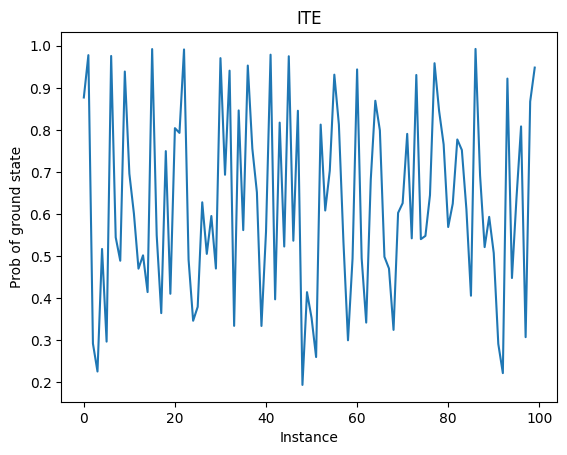

In [12]:
# Plot the list of values
plt.plot(data['ite'])

# Add title and labels
plt.title("ITE")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")

Text(0, 0.5, 'Prob of ground state')

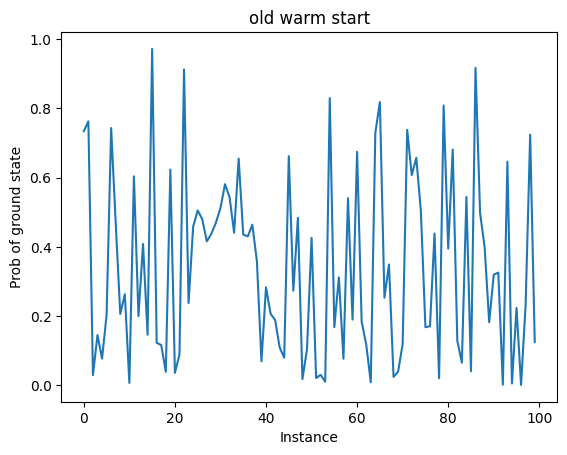

In [172]:
# Plot the list of values
plt.plot(data['old'])

# Add title and labels
plt.title("old warm start")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")

Text(0, 0.5, 'Prob of ground state')

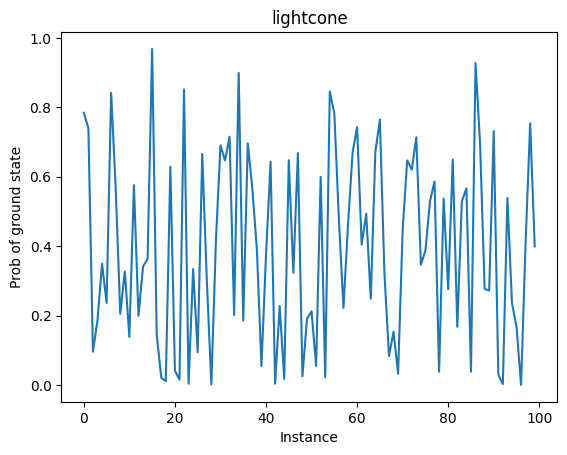

In [174]:
# Plot the list of values
plt.plot(data['light'])

# Add title and labels
plt.title("lightcone")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")

Text(0, 0.5, 'Prob of ground state')

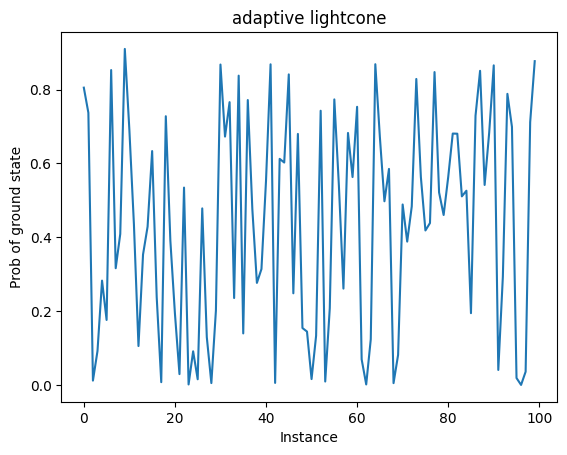

In [175]:
# Plot the list of values
plt.plot(data['adap'])

# Add title and labels
plt.title("adaptive lightcone")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")

Text(0, 0.5, 'Prob of ground state')

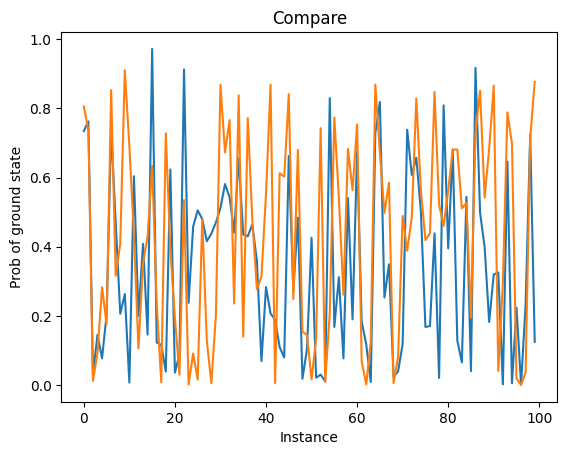

In [176]:
# Plot the list of values
# plt.plot(data['ite'])
plt.plot(data['old'])
#plt.plot(data['light'])
plt.plot(data['adap'])

# Add title and labels
plt.title("Compare")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")

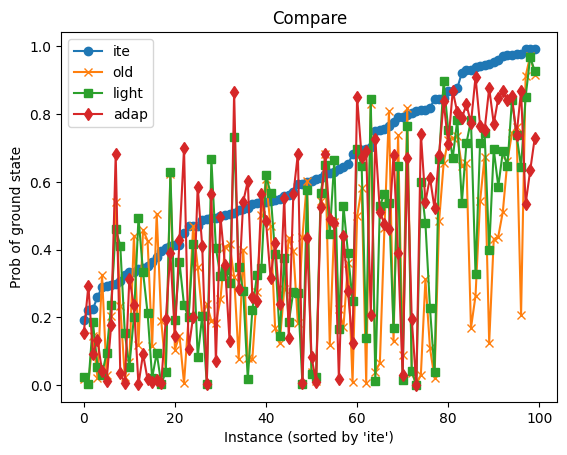

In [255]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['ite'])

# Step 2: Rearrange all lists according to these sorted indices
ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
plt.plot(ite_sorted, label='ite', marker='o')
plt.plot(old_sorted, label='old', marker='x')
plt.plot(light_sorted, label='light', marker='s')
plt.plot(adap_sorted, label='adap', marker='d')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()

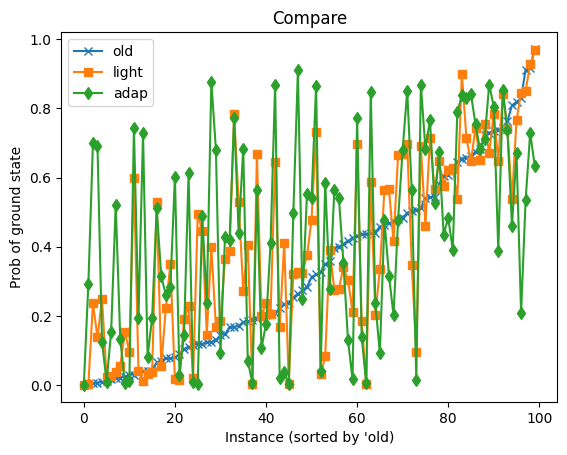

In [178]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['old'])

# Step 2: Rearrange all lists according to these sorted indices
#ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
#plt.plot(ite_sorted, label='ite', marker='o')
plt.plot(old_sorted, label='old', marker='x')
plt.plot(light_sorted, label='light', marker='s')
plt.plot(adap_sorted, label='adap', marker='d')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'old)")
plt.ylabel("Prob of ground state")
plt.legend()

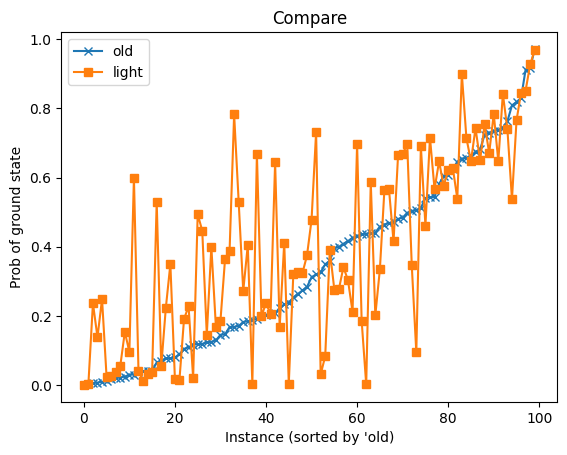

In [179]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['old'])

# Step 2: Rearrange all lists according to these sorted indices
#ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
#adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
#plt.plot(ite_sorted, label='ite', marker='o')
plt.plot(old_sorted, label='old', marker='x')
plt.plot(light_sorted, label='light', marker='s')
#plt.plot(adap_sorted, label='adap', marker='d')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'old)")
plt.ylabel("Prob of ground state")
plt.legend()

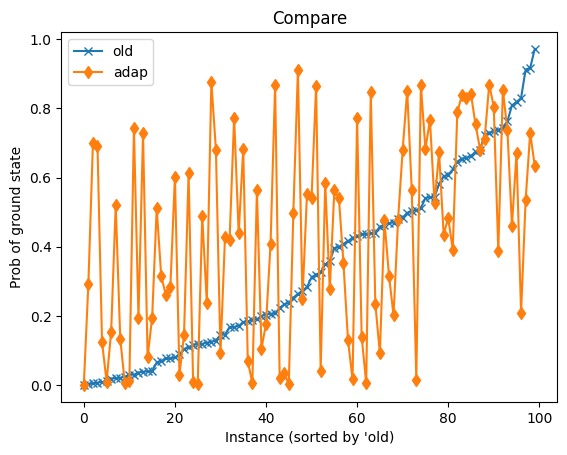

In [180]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['old'])

# Step 2: Rearrange all lists according to these sorted indices
#ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
#light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
#plt.plot(ite_sorted, label='ite', marker='o')
plt.plot(old_sorted, label='old', marker='x')
#plt.plot(light_sorted, label='light', marker='s')
plt.plot(adap_sorted, label='adap', marker='d')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'old)")
plt.ylabel("Prob of ground state")
plt.legend()

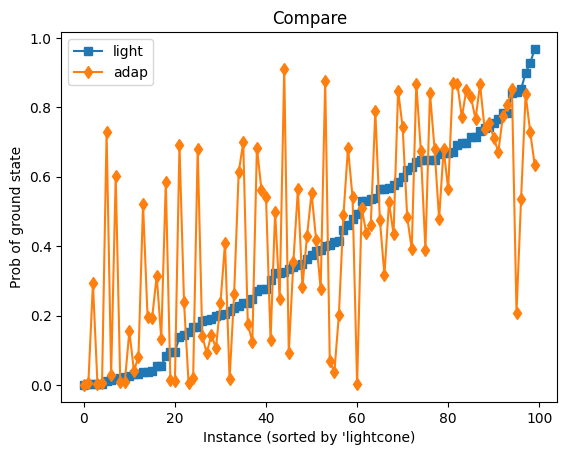

In [181]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['light'])

# Step 2: Rearrange all lists according to these sorted indices
ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
#plt.plot(ite_sorted, label='ite', marker='o')
#plt.plot(old_sorted, label='old', marker='x')
plt.plot(light_sorted, label='light', marker='s')
plt.plot(adap_sorted, label='adap', marker='d')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'lightcone)")
plt.ylabel("Prob of ground state")
plt.legend()

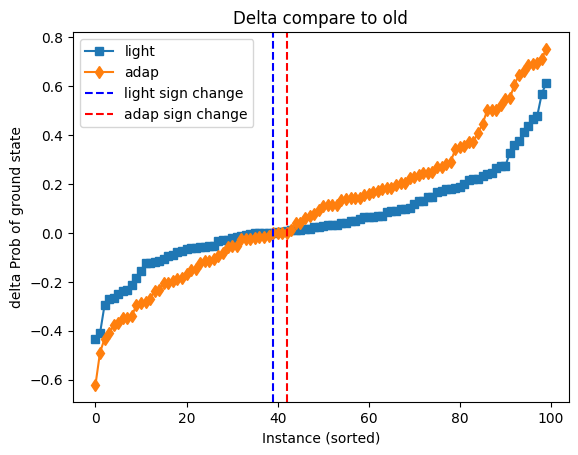

In [28]:
# Calculate the deltas
delta_light = np.array(data['light']) - np.array(data['old'])
delta_adap = np.array(data['adap']) - np.array(data['old'])

# Sort the deltas
delta_light_sorted = np.sort(delta_light)
delta_adap_sorted = np.sort(delta_adap)

# Find the indices where the sign changes from negative to positive
index_light = np.where(np.diff(np.sign(delta_light_sorted)) > 0)[0][0] + 1
index_adap = np.where(np.diff(np.sign(delta_adap_sorted)) > 0)[0][0] + 1

# Plot the sorted deltas
plt.plot(delta_light_sorted, label='light', marker='s')
plt.plot(delta_adap_sorted, label='adap', marker='d')

# Add vertical lines at the indices where the sign changes
plt.axvline(x=index_light, color='blue', linestyle='--', label='light sign change')
plt.axvline(x=index_adap, color='red', linestyle='--', label='adap sign change')

# Add title, labels, and legend
plt.title("Delta compare to old")
plt.xlabel("Instance (sorted)")
plt.ylabel("delta Prob of ground state")
plt.legend()

# Show the plot
plt.show()

In [29]:
# Lists to store the instances where conditions are met
old_greater_than_light = []
light_greater_than_old = []

# Iterate through the lists and compare the values
for i in range(len(data['old'])):
    if data['old'][i] > data['light'][i]:
        old_greater_than_light.append(i)  # Save corresponding 'ite' value
    elif data['light'][i] > data['old'][i]:
        light_greater_than_old.append(i)  # Save corresponding 'ite' value

# Print the results
print("Instances where 'old' > 'light':", old_greater_than_light)
print("Instances where 'light' > 'old':", light_greater_than_old)

print("Instances where 'old' > 'light':", len(old_greater_than_light))
print("Instances where 'light' > 'old':", len(light_greater_than_old))

Instances where 'old' > 'light': [1, 8, 11, 12, 13, 15, 17, 18, 21, 22, 23, 24, 25, 27, 28, 29, 33, 35, 39, 42, 44, 45, 50, 58, 64, 65, 67, 69, 71, 74, 79, 80, 81, 85, 88, 91, 93, 95, 96]
Instances where 'light' > 'old': [0, 2, 3, 4, 5, 6, 7, 9, 10, 14, 16, 19, 20, 26, 30, 31, 32, 34, 36, 37, 38, 40, 41, 43, 46, 47, 48, 49, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 66, 68, 70, 72, 73, 75, 76, 77, 78, 82, 83, 84, 86, 87, 89, 90, 92, 94, 97, 98, 99]
Instances where 'old' > 'light': 39
Instances where 'light' > 'old': 61


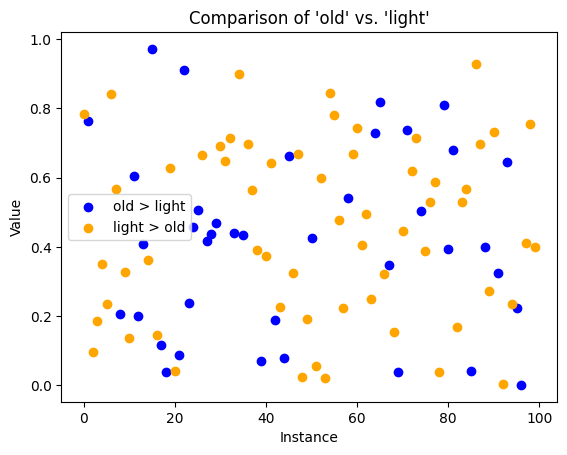

In [30]:
# Plot values where old > light
plt.scatter(old_greater_than_light, np.array(data['old'])[old_greater_than_light], color='blue', label='old > light')

# Plot values where light > old
plt.scatter(light_greater_than_old, np.array(data['light'])[light_greater_than_old], color='orange', label='light > old')

# Add title, labels, and legend
plt.title("Comparison of 'old' vs. 'light'")
plt.xlabel("Instance")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

In [31]:
# Lists to store the instances where conditions are met
old_greater_than_adap = []
adap_greater_than_old = []

# Iterate through the lists and compare the values
for i in range(len(data['old'])):
    if data['old'][i] > data['adap'][i]:
        old_greater_than_adap.append(i)  # Save corresponding 'ite' value
    elif data['adap'][i] > data['old'][i]:
        adap_greater_than_old.append(i)  # Save corresponding 'ite' value

# Print the results
print("Instances where 'old' > 'adap':", old_greater_than_adap)
print("Instances where 'adap' > 'old':", adap_greater_than_old)

print("Instances where 'old' > 'adap':", len(old_greater_than_adap))
print("Instances where 'adap' > 'old':", len(adap_greater_than_old))

Instances where 'old' > 'adap': [1, 2, 3, 5, 7, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 35, 38, 42, 46, 50, 53, 54, 61, 62, 65, 68, 71, 72, 79, 84, 86, 91, 95, 96, 97, 98]
Instances where 'adap' > 'old': [0, 4, 6, 8, 9, 10, 14, 16, 18, 20, 30, 31, 32, 34, 36, 37, 39, 40, 41, 43, 44, 45, 47, 48, 49, 51, 52, 55, 56, 57, 58, 59, 60, 63, 64, 66, 67, 69, 70, 73, 74, 75, 76, 77, 78, 80, 82, 83, 85, 87, 88, 89, 90, 92, 93, 94, 99]
Instances where 'old' > 'adap': 42
Instances where 'adap' > 'old': 57


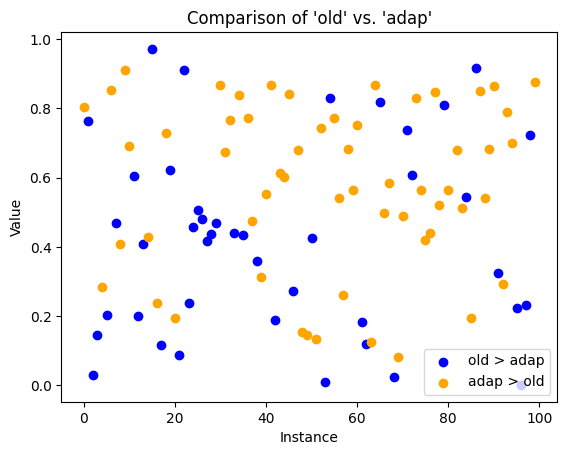

In [32]:
# Plot values where old > light
plt.scatter(old_greater_than_adap, np.array(data['old'])[old_greater_than_adap], color='blue', label='old > adap')

# Plot values where light > old
plt.scatter(adap_greater_than_old, np.array(data['adap'])[adap_greater_than_old], color='orange', label='adap > old')

# Add title, labels, and legend
plt.title("Comparison of 'old' vs. 'adap'")
plt.xlabel("Instance")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

In [33]:
# Lists to store the instances where conditions are met
light_greater_than_adap = []
adap_greater_than_light = []

# Iterate through the lists and compare the values
for i in range(len(data['light'])):
    if data['light'][i] > data['adap'][i]:
        light_greater_than_adap.append(i)  # Save corresponding 'ite' value
    elif data['adap'][i] > data['light'][i]:
        adap_greater_than_light.append(i)  # Save corresponding 'ite' value

# Print the results
print("Instances where 'light' > 'adap':", light_greater_than_adap)
print("Instances where 'adap' > 'light':", adap_greater_than_light)

print("Instances where 'light' > 'adap':", len(light_greater_than_adap))
print("Instances where 'adap' > 'light':", len(adap_greater_than_light))

Instances where 'light' > 'adap': [1, 2, 3, 4, 5, 7, 11, 12, 15, 17, 19, 22, 23, 24, 25, 26, 27, 29, 34, 35, 37, 38, 46, 49, 50, 53, 54, 55, 59, 61, 62, 63, 65, 68, 71, 72, 76, 79, 83, 84, 86, 95, 97, 98]
Instances where 'adap' > 'light': [0, 6, 8, 9, 10, 13, 14, 16, 18, 20, 21, 28, 30, 31, 32, 33, 36, 39, 40, 41, 42, 43, 44, 45, 47, 48, 51, 52, 56, 57, 58, 60, 64, 66, 67, 69, 70, 73, 74, 75, 77, 78, 80, 81, 82, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 99]
Instances where 'light' > 'adap': 44
Instances where 'adap' > 'light': 56


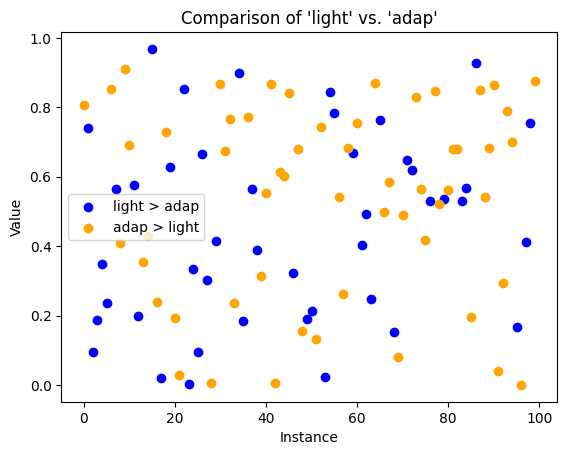

In [34]:
# Plot values where old > light
plt.scatter(light_greater_than_adap, np.array(data['light'])[light_greater_than_adap], color='blue', label='light > adap')

# Plot values where light > old
plt.scatter(adap_greater_than_light, np.array(data['adap'])[adap_greater_than_light], color='orange', label='adap > light')

# Add title, labels, and legend
plt.title("Comparison of 'light' vs. 'adap'")
plt.xlabel("Instance")
plt.ylabel("Value")
plt.legend()

# Show the plot
plt.show()

In [35]:
# Print the results
print("Instances where 'old' > 'light':", len(old_greater_than_light))
print("Instances where 'old' > 'light':\n", old_greater_than_light)
# delta = np.array(data['old'] ) - np.array( data['light']) 
# print('difference', delta)

print("\nInstances where 'old' > 'adap':", len(old_greater_than_adap))
print("Instances where 'old' > 'adap':\n", old_greater_than_adap)

print("\nInstances where 'adap' > 'light':", len(adap_greater_than_light))
print("Instances where 'adap' > 'light':\n", adap_greater_than_light)

common =  [element for element in old_greater_than_light if element in old_greater_than_adap]
print('\nInstances where old grater than both:',len(common))
print('Instances where old grater than both:', common)
print('exp_poss old case', np.sort(np.array(data['old'])[common]))

common_good =  [element for element in old_greater_than_light if element in adap_greater_than_light]
print('\nInstances where improved:',len(common_good))
print('Instances where improved:', common_good)

print('\n exp_poss old case', np.array(data['old'])[common])
print('\n exp_poss ite when old is better',np.array(data['ite'])[common])
print(sum(np.array(data['ite'])[common]) / len(np.array(data['ite'])[common]))
print('\n exp_poss ite when old is better',np.array(data['ite'])[old_greater_than_light])
print(sum(np.array(data['ite'])[old_greater_than_light]) / len(np.array(data['ite'])[old_greater_than_light]))
print('\n exp_poss ite when old is not better',np.array(data['ite'])[light_greater_than_old])
print(sum(np.array(data['ite'])[light_greater_than_old]) / len(np.array(data['ite'])[light_greater_than_old]))

Instances where 'old' > 'light': 39
Instances where 'old' > 'light':
 [1, 8, 11, 12, 13, 15, 17, 18, 21, 22, 23, 24, 25, 27, 28, 29, 33, 35, 39, 42, 44, 45, 50, 58, 64, 65, 67, 69, 71, 74, 79, 80, 81, 85, 88, 91, 93, 95, 96]

Instances where 'old' > 'adap': 42
Instances where 'old' > 'adap':
 [1, 2, 3, 5, 7, 11, 12, 13, 15, 17, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 35, 38, 42, 46, 50, 53, 54, 61, 62, 65, 68, 71, 72, 79, 84, 86, 91, 95, 96, 97, 98]

Instances where 'adap' > 'light': 56
Instances where 'adap' > 'light':
 [0, 6, 8, 9, 10, 13, 14, 16, 18, 20, 21, 28, 30, 31, 32, 33, 36, 39, 40, 41, 42, 43, 44, 45, 47, 48, 51, 52, 56, 57, 58, 60, 64, 66, 67, 69, 70, 73, 74, 75, 77, 78, 80, 81, 82, 85, 87, 88, 89, 90, 91, 92, 93, 94, 96, 99]

Instances where old grater than both: 24
Instances where old grater than both: [1, 11, 12, 13, 15, 17, 21, 22, 23, 24, 25, 27, 28, 29, 33, 35, 42, 50, 65, 71, 79, 91, 95, 96]
exp_poss old case [0.00152958 0.08918196 0.11656667 0.18911006 0.2001758

In [36]:
N = 6
tau = 1

print('tot instances old is better', len(common))
print('tot instances old is better', common)
print('exp_poss old case', np.array(data['old'])[common])
print('exp_poss old case', np.sort(np.array(data['old'])[common]))
print('exp_poss old case', np.argsort(np.array(data['old'])[common]))

for r in common:

    print('\n\n#############################################################################')
    print('r:', r)

    #region load qubo instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N )
    with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
        G = pickle.load(f)
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    print('h_list', h_list)
    print('J_list', J_list)

tot instances old is better 24
tot instances old is better [1, 11, 12, 13, 15, 17, 21, 22, 23, 24, 25, 27, 28, 29, 33, 35, 42, 50, 65, 71, 79, 91, 95, 96]
exp_poss old case [0.76246218 0.60386562 0.20017584 0.40863218 0.97162603 0.11656667
 0.08918196 0.91213708 0.23798743 0.45814317 0.50532528 0.41605069
 0.43782103 0.47006043 0.44097434 0.43557457 0.18911006 0.42611306
 0.81821181 0.73808465 0.80845963 0.32578833 0.22370465 0.00152958]
exp_poss old case [0.00152958 0.08918196 0.11656667 0.18911006 0.20017584 0.22370465
 0.23798743 0.32578833 0.40863218 0.41605069 0.42611306 0.43557457
 0.43782103 0.44097434 0.45814317 0.47006043 0.50532528 0.60386562
 0.73808465 0.76246218 0.80845963 0.81821181 0.91213708 0.97162603]
exp_poss old case [23  6  5 16  2 22  8 21  3 11 17 15 12 14  9 13 10  1 19  0 20 18  7  4]


#############################################################################
r: 1
h_list [ 0.2069  0.3161  0.6897 -0.1795  0.014  -0.8408]
J_list [-0.9759 -0.0697  0.1948 -0.87

In [37]:
#worst case old
for r in [96]:

    print('\n\n#############################################################################')
    print('r:', r)

    #region load qubo instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N )
    with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
        G = pickle.load(f)
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    print('h_list', h_list)
    print('J_list', J_list)



#############################################################################
r: 96
h_list [ 0.0622  0.2287  0.1736 -0.8584  0.5974  0.842 ]
J_list [ 0.8606 -0.0714 -0.7467  0.2465  0.6304  0.7322  0.9989  0.3355  0.7586
  0.9749  0.7827 -0.7868  0.2756 -0.8275  0.621 ]


In [216]:
N = 6
tau = 1

# Define color codes
RESET = '\033[0m'   # Reset to default color
RED = '\033[91m'    # Red text
# GREEN = '\033[92m'  # Green text
# BLUE = '\033[94m'   # Blue text

for r in range(100):
    print('\n\n#############################################################################')
    print('r:', r)
    
    # Load QUBO instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N)
    
    with open(instance_dir + '/QUBO_' + str(N) + 'V_comp_' + '.gpickle', 'rb') as f:
        G = pickle.load(f)
        
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_' + 'r_' + str(r) + '.txt')
    h_list = coeff_list[:N]
    J_list = coeff_list[N:]
    
    # Print lists with different colors based on the condition
    if r in old_greater_than_light:
        print(RED + 'h_list:', h_list, RESET)
        print(RED + 'J_list:', J_list, RESET)
    else:
        print( 'h_list:', h_list)
        print( 'J_list:', J_list)



#############################################################################
r: 0
h_list: [-0.3086 -0.696  -0.1554 -0.5975  0.2585 -0.6503]
J_list: [-0.131  -0.3423  0.3119  0.6694  0.6471 -0.1737 -0.6502  0.5129 -0.6717
 -0.8486  0.9982  0.0338  0.6982 -0.9141  0.4205]


#############################################################################
r: 1
h_list: [ 0.2069  0.3161  0.6897 -0.1795  0.014  -0.8408] 
J_list: [-0.9759 -0.0697  0.1948 -0.8734  0.3924 -0.0169  0.4045 -0.1273  0.1804
  0.3248 -0.4752 -0.2987  0.5299  0.5184  0.8678] 


#############################################################################
r: 2
h_list: [ 0.0149  0.4015  0.0728  0.2417 -0.5214 -0.4826]
J_list: [-0.7054  0.3396  0.0068  0.4756  0.8811 -0.1607  0.6827 -0.8025  0.5465
  0.5658  0.5911  0.1532  0.757  -0.7003  0.3551]


#############################################################################
r: 3
h_list: [ 0.8226  0.0188 -0.6101  0.8173  0.9489 -0.7316]
J_list: [-0.1347 -0.3163  0.3997 

In [39]:
N = 6
tau = 1

# Define color codes
RESET = '\033[0m'   # Reset to default color
RED = '\033[91m'    # Red text
# GREEN = '\033[92m'  # Green text
# BLUE = '\033[94m'   # Blue text

for r in range(100):
    print('\n\n#############################################################################')
    print('r:', r)
    
    # Load QUBO instances, get Hamiltonian and edge_coeff_dict
    instance_dir = '../instances/complete/N_' + str(N)
    
    with open(instance_dir + '/QUBO_' + str(N) + 'V_comp_' + '.gpickle', 'rb') as f:
        G = pickle.load(f)
        
    coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_' + 'r_' + str(r) + '.txt')
    h_list = coeff_list[:N]
    J_list = coeff_list[N:]
    
    edge_list = G.edges()
    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})

    edges_columns = partition_N(N)

    # # Print lists with different colors based on the condition
    # if r in old_greater_than_light:
    #     print(RED + 'h_list:', h_list, RESET)
    #     print(RED + 'J_list:', J_list, RESET)
    # else:
    #     print( 'h_list:', h_list)
    #     print( 'J_list:', J_list)

    
    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        if r in old_greater_than_light:
            print(RED , 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
        else:
            print( 'col: ', column_index, toprint, sum_j, abs_sum_j)




#############################################################################
r: 0
col:  0 [-0.131, -0.8486, 0.4205] -0.5591 1.4001000000000001
col:  1 [0.3119, 0.0338] 0.3457 0.3457
col:  2 [-0.6502, 0.6471, 0.9982] 0.9951 2.2954999999999997
col:  3 [-0.6717, 0.6694] -0.0022999999999999687 1.3411
col:  4 [-0.9141, 0.5129, -0.3423] -0.7435 1.7693
col:  5 [0.6982, -0.1737] 0.5245000000000001 0.8719


#############################################################################
r: 1
 col:  0 [-0.9759, 0.3248, 0.8678] 0.2167 2.1685 
 col:  1 [0.1948, -0.2987] -0.10390000000000002 0.49350000000000005 
 col:  2 [0.4045, 0.3924, -0.4752] 0.32170000000000004 1.2721 
 col:  3 [0.1804, -0.8734] -0.693 1.0537999999999998 
 col:  4 [0.5184, -0.1273, -0.0697] 0.3214 0.7153999999999999 
 col:  5 [0.5299, -0.0169] 0.513 0.5468000000000001 


#############################################################################
r: 2
col:  0 [-0.7054, 0.5658, 0.3551] 0.21549999999999997 1.6262999999999999
co

In [40]:
N = 6
tau = 1
r = 96
Numpara = 2

print('\n\n#############################################################################')
print('tau:', tau)


#region load qubo instances, get Hamiltonian and edge_coeff_dict
instance_dir = '../instances/complete/N_' + str(N )
with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
    G = pickle.load(f)
coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
h_list = coeff_list[: N ]
J_list = coeff_list[N :]

edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)
edge_list = G.edges()
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
# print('lightcone_dict', lightcone_dict)
# print('edges_columns', edges_columns)
# print('pairs_all', pairs_all)
# print('edge_list', edge_list)

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
# print('Hamiltonian', H)
# print('eigen list', eigen_list[:13])
# print('eigen list sorted',  np.sort(eigen_list))

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
# print('edge_coeff_dict' , edge_coeff_dict)

# Print lists with different colors based on the condition
for column_index, column in enumerate(edges_columns):
    toprint = []
    sum_j = 0 
    abs_sum_j = 0
    for edge in column:
        toprint.append(edge_coeff_dict[edge])  
        sum_j += edge_coeff_dict[edge]
        abs_sum_j += abs(edge_coeff_dict[edge])
    if r in old_greater_than_light:
        print(RED , 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    else:
        print( 'col: ', column_index, toprint, sum_j, abs_sum_j)

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
print('exp_poss_dict', list(exp_poss_dict.items())[0])

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
Ampth = 0.0 
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
Ampth = 0.9
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
tau: 1
 col:  0 [0.8606, 0.9749, 0.621] 2.4565 2.4565 
 col:  1 [-0.7467, -0.7868] -1.5335 1.5335 
 col:  2 [0.9989, 0.6304, 0.7827] 2.412 2.412 
 col:  3 [0.7586, 0.2465] 1.0051 1.0051 
 col:  4 [-0.8275, 0.3355, -0.0714] -0.5634 1.2344 
 col:  5 [0.2756, 0.7322] 1.0078 1.0078 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-6.3744, 0.808237331123588)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old

edge:  (0, 1) ,  coeff:  0.8606 ,     final square modulus:  -0.9963347899152716

edge:  (2, 3) ,  coeff:  0.9749 ,     final square modulus:  -0.9984303240533428

edge:  (4, 5) ,  coeff:  0.621 ,     final square modulus:  -0.9567708387896553

edge:  (0, 3) ,  coeff:  -0.7467 ,     final square modulus:  -0.8448693255926538

edge:  (2, 5) ,  coeff:  -0.7868 ,     final square modulus:  -0.9384368855368403

edge:  (1, 3) ,  coeff:  0.9989 ,     final square modulus:  -0.8102445294924946

edge

In [43]:
N = 6
tau = 1
r = 21
Numpara = 2

print('\n\n#############################################################################')
print('tau:', tau)


#region load qubo instances, get Hamiltonian and edge_coeff_dict
instance_dir = '../instances/complete/N_' + str(N )
with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
    G = pickle.load(f)
coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
h_list = coeff_list[: N ]
J_list = coeff_list[N :]

edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)
edge_list = G.edges()
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
# print('lightcone_dict', lightcone_dict)
# print('edges_columns', edges_columns)
# print('pairs_all', pairs_all)
# print('edge_list', edge_list)

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
# print('Hamiltonian', H)
# print('eigen list', eigen_list[:13])
# print('eigen list sorted',  np.sort(eigen_list))

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
# print('edge_coeff_dict' , edge_coeff_dict)

# Print lists with different colors based on the condition
for column_index, column in enumerate(edges_columns):
    toprint = []
    sum_j = 0 
    abs_sum_j = 0
    for edge in column:
        toprint.append(edge_coeff_dict[edge])  
        sum_j += edge_coeff_dict[edge]
        abs_sum_j += abs(edge_coeff_dict[edge])
    if r in old_greater_than_light:
        print(RED , 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    else:
        print( 'col: ', column_index, toprint, sum_j, abs_sum_j)

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
print('exp_poss_dict', list(exp_poss_dict.items())[0])

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
Ampth = 0.0 
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
Ampth = 0.9
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
tau: 1
 col:  0 [0.0797, 0.4603, 0.5841] 1.1240999999999999 1.1240999999999999 
 col:  1 [-0.7014, -0.79] -1.4914 1.4914 
 col:  2 [0.2928, -0.8505, -0.3469] -0.9046000000000001 1.4902 
 col:  3 [0.8694, 0.1877] 1.0571 1.0571 
 col:  4 [-0.6211, 0.0929, 0.8232] 0.29500000000000004 1.5372 
 col:  5 [-0.1857, -0.1352] -0.32089999999999996 0.32089999999999996 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-5.378000000000001, 0.7927997170384106)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old

edge:  (0, 1) ,  coeff:  0.0797 ,     final square modulus:  -0.9996257881502972

edge:  (2, 3) ,  coeff:  0.4603 ,     final square modulus:  -0.986105426746942

edge:  (4, 5) ,  coeff:  0.5841 ,     final square modulus:  -0.9961278051078147

edge:  (0, 3) ,  coeff:  -0.7014 ,     final square modulus:  -0.9153504658734479

edge:  (2, 5) ,  coeff:  -0.79 ,     final square modulus:  -0.75477364539325

In [44]:
N = 6
tau = 1
r = 88
Numpara = 2

print('\n\n#############################################################################')
print('tau:', tau)

#region load qubo instances, get Hamiltonian and edge_coeff_dict
instance_dir = '../instances/complete/N_' + str(N )
with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
    G = pickle.load(f)
coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
h_list = coeff_list[: N ]
J_list = coeff_list[N :]

edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)
edge_list = G.edges()
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
# print('lightcone_dict', lightcone_dict)
# print('edges_columns', edges_columns)
# print('pairs_all', pairs_all)
# print('edge_list', edge_list)

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
# print('Hamiltonian', H)
# print('eigen list', eigen_list[:13])
# print('eigen list sorted',  np.sort(eigen_list))

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
# print('edge_coeff_dict' , edge_coeff_dict)

# Print lists with different colors based on the condition
for column_index, column in enumerate(edges_columns):
    toprint = []
    sum_j = 0 
    abs_sum_j = 0
    for edge in column:
        toprint.append(edge_coeff_dict[edge])  
        sum_j += edge_coeff_dict[edge]
        abs_sum_j += abs(edge_coeff_dict[edge])
    if r in old_greater_than_light:
        print(RED , 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    else:
        print( 'col: ', column_index, toprint, sum_j, abs_sum_j)

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
print('exp_poss_dict', list(exp_poss_dict.items())[0])

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
Ampth = 0.0 
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
Ampth = 0.9
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
tau: 1
 col:  0 [-0.716, 0.2257, 0.3266] -0.16369999999999996 1.2683 
 col:  1 [-0.8522, 0.0848] -0.7674 0.9369999999999999 
 col:  2 [0.1282, -0.9182, -0.3898] -1.1798 1.4362 
 col:  3 [0.2723, -0.7429] -0.4706 1.0152 
 col:  4 [-0.5204, 0.1838, -0.0296] -0.3662 0.7337999999999999 
 col:  5 [-0.964, -0.2306] -1.1945999999999999 1.1945999999999999 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-5.0904, 0.5211451940146543)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old

edge:  (0, 1) ,  coeff:  -0.716 ,     final square modulus:  -0.9972458741347457

edge:  (2, 3) ,  coeff:  0.2257 ,     final square modulus:  -0.9999834833535007

edge:  (4, 5) ,  coeff:  0.3266 ,     final square modulus:  -0.9981837309551993

edge:  (0, 3) ,  coeff:  -0.8522 ,     final square modulus:  -0.9609870201188606

edge:  (2, 5) ,  coeff:  0.0848 ,     final square modulus:  -0.9990079694058244

edge:  (1, 3) 

In [45]:
N = 6
tau = 1
r = 79
Numpara = 2

print('\n\n#############################################################################')
print('tau:', tau)


#region load qubo instances, get Hamiltonian and edge_coeff_dict
instance_dir = '../instances/complete/N_' + str(N )
with open(instance_dir + '/QUBO_' + str(N ) + 'V_comp_'+ '.gpickle', 'rb') as f:
    G = pickle.load(f)
coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(N) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
h_list = coeff_list[: N ]
J_list = coeff_list[N :]

edges_columns = partition_N(N)
lightcone_dict = find_light_cone(edges_columns)
edge_list = G.edges()
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
# print('lightcone_dict', lightcone_dict)
# print('edges_columns', edges_columns)
# print('pairs_all', pairs_all)
# print('edge_list', edge_list)

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(N, edge_list, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
# print('Hamiltonian', H)
# print('eigen list', eigen_list[:13])
# print('eigen list sorted',  np.sort(eigen_list))

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
# print('edge_coeff_dict' , edge_coeff_dict)

# Print lists with different colors based on the condition
for column_index, column in enumerate(edges_columns):
    toprint = []
    sum_j = 0 
    abs_sum_j = 0
    for edge in column:
        toprint.append(edge_coeff_dict[edge])  
        sum_j += edge_coeff_dict[edge]
        abs_sum_j += abs(edge_coeff_dict[edge])
    if r in old_greater_than_light:
        print(RED , 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)
    else:
        print( 'col: ', column_index, toprint, sum_j, abs_sum_j)
        
print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
print('exp_poss_dict', list(exp_poss_dict.items())[0])

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
Ampth = 0.0 
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))

print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
Ampth = 0.9
edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
# print('edge_params_dict', edge_params_dict)
print('exp_poss_dict', list(exp_poss_dict.items())[0])
print('overlap btw ite and opt state', np.dot(state_ite, state_all))



#############################################################################
tau: 1
 col:  0 [-0.2945, 0.3344, -0.1559] -0.11600000000000002 0.7848 
 col:  1 [-0.9288, -0.3569] -1.2856999999999998 1.2856999999999998 
 col:  2 [0.2026, -0.5751, 0.6707] 0.2982 1.4484 
 col:  3 [-0.2703, -0.7237] -0.994 0.994 
 col:  4 [0.889, -0.9306, -0.9452] -0.9868 2.7648 
 col:  5 [-0.2354, 0.4749] 0.2395 0.7102999999999999 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-6.6287, 0.7654602627675303)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old

edge:  (0, 1) ,  coeff:  -0.2945 ,     final square modulus:  -0.9992209769583159

edge:  (2, 3) ,  coeff:  0.3344 ,     final square modulus:  -0.9927419694291708

edge:  (4, 5) ,  coeff:  -0.1559 ,     final square modulus:  -0.999776283892928

edge:  (0, 3) ,  coeff:  -0.9288 ,     final square modulus:  -0.980469212673192

edge:  (2, 5) ,  coeff:  -0.3569 ,     final square modulus:  -0.992814149443809

edge:  (1, 3) ,  coeff:  0.2

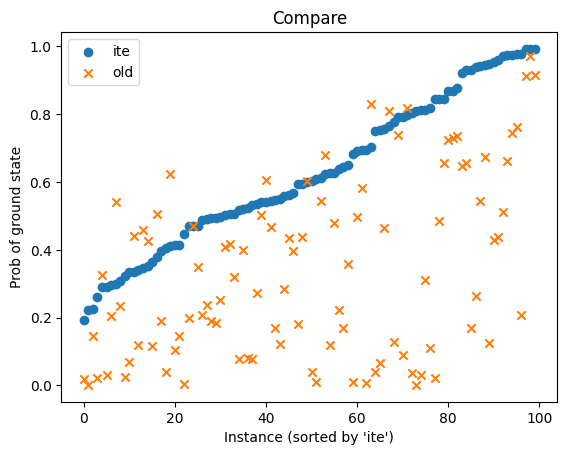

In [22]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['ite'])

# Step 2: Rearrange all lists according to these sorted indices
ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
plt.scatter( range(100), ite_sorted, label='ite', marker='o')
plt.scatter( range(100), old_sorted, label='old', marker='x')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()



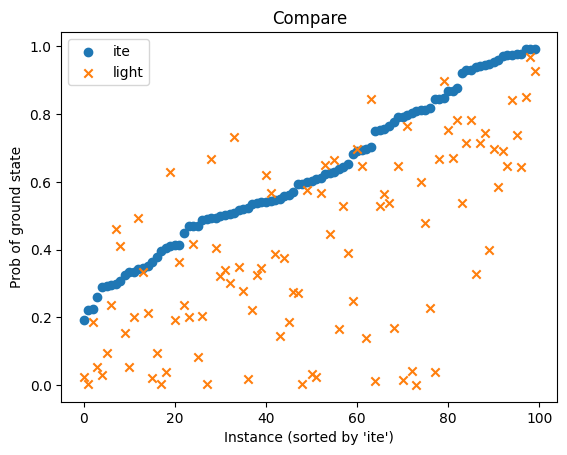

In [26]:
# Step 3: Plot the sorted lists
plt.scatter( range(100), ite_sorted, label='ite', marker='o')
plt.scatter( range(100), light_sorted, label='light', marker='x')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()


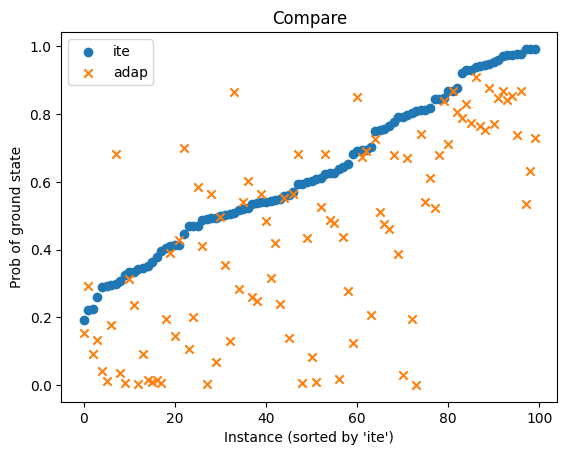

In [25]:
# Step 3: Plot the sorted lists
plt.scatter( range(100), ite_sorted, label='ite', marker='o')
plt.scatter( range(100), adap_sorted, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()

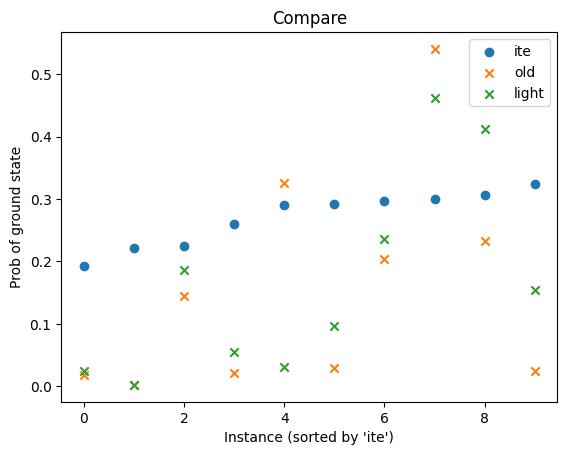

In [50]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['ite'])

# Step 2: Rearrange all lists according to these sorted indices
ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
plt.scatter( range(10), ite_sorted[:10], label='ite', marker='o')
plt.scatter( range(10), old_sorted[:10], label='old', marker='x')
plt.scatter( range(10), light_sorted[:10], label='light', marker='x')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()

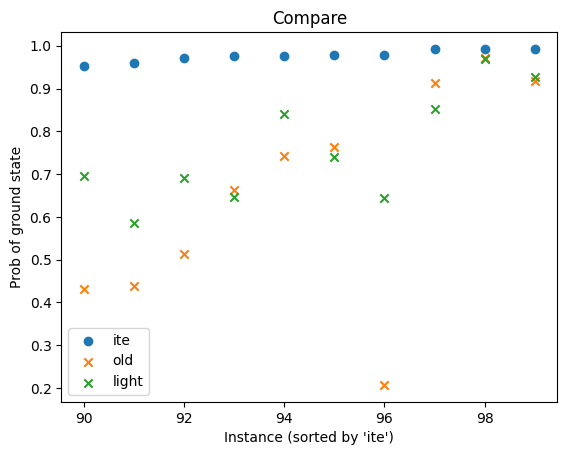

In [49]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['ite'])

# Step 2: Rearrange all lists according to these sorted indices
ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
plt.scatter( range(90,100), ite_sorted[90 :], label='ite', marker='o')
plt.scatter( range(90,100), old_sorted[90:], label='old', marker='x')
plt.scatter( range(90,100), light_sorted[90:], label='light', marker='x')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()

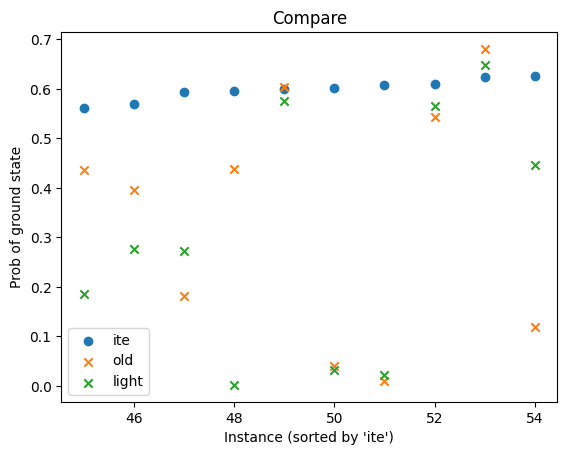

In [52]:
# Step 1: Get the sorted indices of 'ite'
sorted_indices = np.argsort(data['ite'])

# Step 2: Rearrange all lists according to these sorted indices
ite_sorted = np.array(data['ite'])[sorted_indices]
old_sorted = np.array(data['old'])[sorted_indices]
light_sorted = np.array(data['light'])[sorted_indices]
adap_sorted = np.array(data['adap'])[sorted_indices]

# Step 3: Plot the sorted lists
plt.scatter( range(45,55), ite_sorted[45:55], label='ite', marker='o')
plt.scatter( range(45,55), old_sorted[45:55], label='old', marker='x')
plt.scatter(range(45,55), light_sorted[45:55], label='light', marker='x')

# Add title, labels, and legend
plt.title("Compare")
plt.xlabel("Instance (sorted by 'ite')")
plt.ylabel("Prob of ground state")
plt.legend()

In [53]:
import networkx as nx
from networkx import random_graphs



#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  0.9398197   0.73235229  0.66488528  0.41614516  0.22370579  0.20223002
  0.04951286 -0.13610996 -0.39151551 -0.41754172 -0.57532178 -0.63319098
 -0.63635007 -0.88383278 -0.95883101]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [0.9398197043239886, 0.7323522915498704, 0.6648852816008435] 2.3370572774747025 2.3370572774747025 
 col:  1 [0.416145155592091, 0.22370578944475894] 0.6398509450368499 0.6398509450368499 
 col:  2 [0.2022300234864176, 0.04951286326447568, -0.13610996271576847] 0.11563292403512482 0.38785284946666176 
 col:  3 [-0.39151551408092455, -0.4175417196039162] -0.8090572336848407 0.8090572336848407 
 col:  4 [-0.5753217786434477, -0.6331909802931324, -0.6363500655857988] -1.8448628245223788 1.8448628245223788 
 col:  5 [-0.8838327756636011, -0.9588310114083951] -1.8426637870719962 1.8426637870719962 

~~~

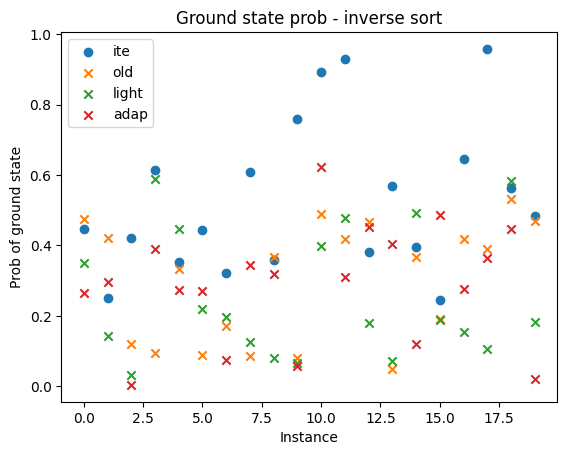

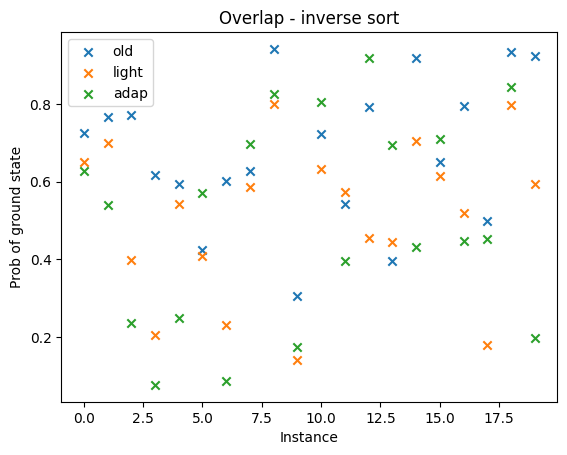

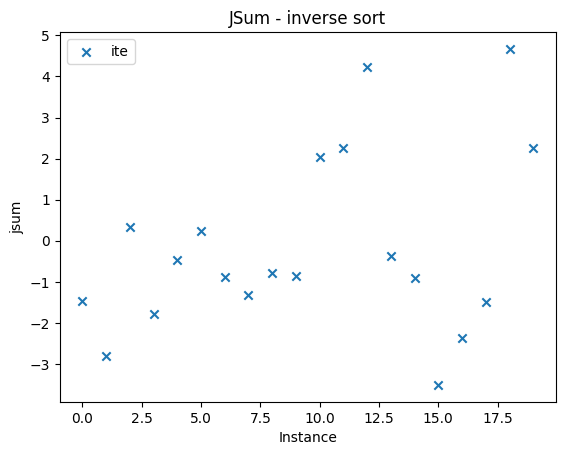

In [149]:
# Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 20
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs = np.sort(edge_coeffs)[::-1]
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - inverse sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()





#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.95883101 -0.88383278 -0.63635007 -0.63319098 -0.57532178 -0.41754172
 -0.39151551 -0.13610996  0.04951286  0.20223002  0.22370579  0.41614516
  0.66488528  0.73235229  0.9398197 ]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [-0.9588310114083951, -0.8838327756636011, -0.6363500655857988] -2.479013852657795 2.479013852657795 
 col:  1 [-0.6331909802931324, -0.5753217786434477] -1.20851275893658 1.20851275893658 
 col:  2 [-0.4175417196039162, -0.39151551408092455, -0.13610996271576847] -0.9451671964006092 0.9451671964006092 
 col:  3 [0.04951286326447568, 0.2022300234864176] 0.2517428867508933 0.2517428867508933 
 col:  4 [0.22370578944475894, 0.416145155592091, 0.6648852816008435] 1.3047362266376934 1.3047362266376934 
 col:  5 [0.7323522915498704, 0.9398197043239886] 1.672171995873859 1.672171995873859 

~~~~~~~~~~~~~

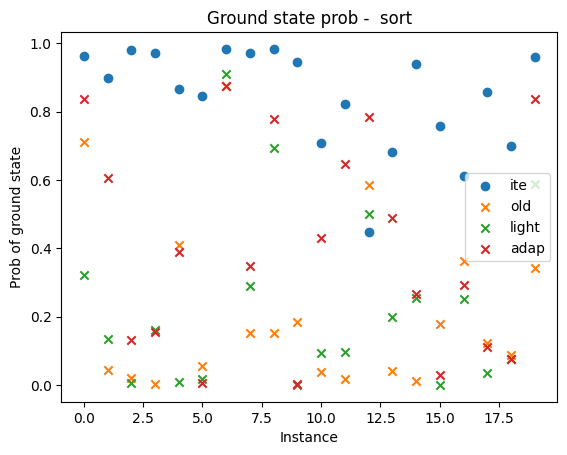

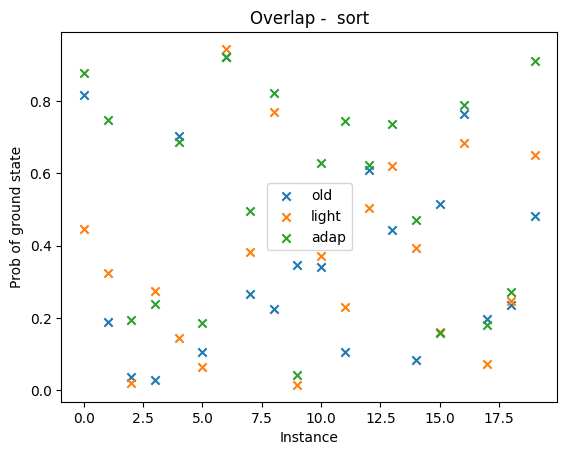

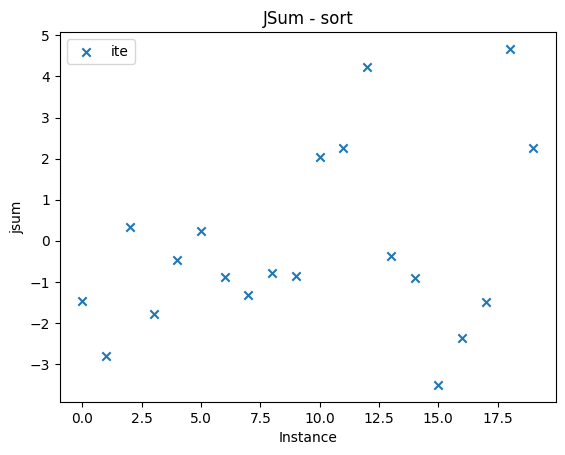

In [174]:
#SORT 
# Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 20
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs = np.sort(edge_coeffs)
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()





#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.95883101  0.9398197  -0.88383278  0.73235229  0.66488528 -0.63635007
 -0.63319098 -0.57532178 -0.41754172  0.41614516 -0.39151551  0.22370579
  0.20223002 -0.13610996  0.04951286]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [-0.9588310114083951, 0.9398197043239886, -0.8838327756636011] -0.9028440827480075 2.782483491395985 
 col:  1 [0.7323522915498704, 0.6648852816008435] 1.3972375731507138 1.3972375731507138 
 col:  2 [-0.6363500655857988, -0.6331909802931324, -0.5753217786434477] -1.8448628245223788 1.8448628245223788 
 col:  3 [-0.4175417196039162, 0.416145155592091] -0.0013965640118251965 0.8336868751960071 
 col:  4 [-0.39151551408092455, 0.22370578944475894, 0.2022300234864176] 0.034420298850251996 0.8174513270121011 
 col:  5 [-0.13610996271576847, 0.04951286326447568] -0.08659709945129279 0.18562282598024415 

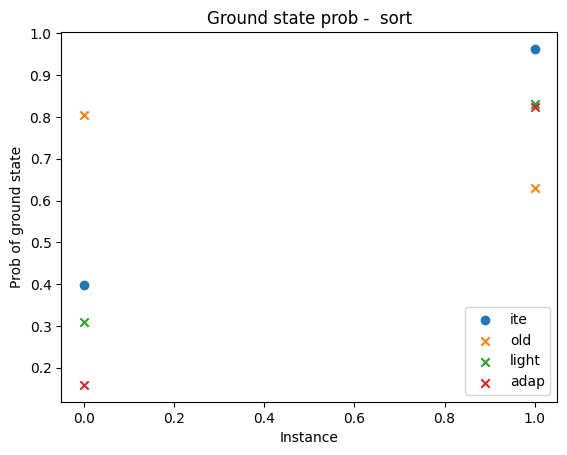

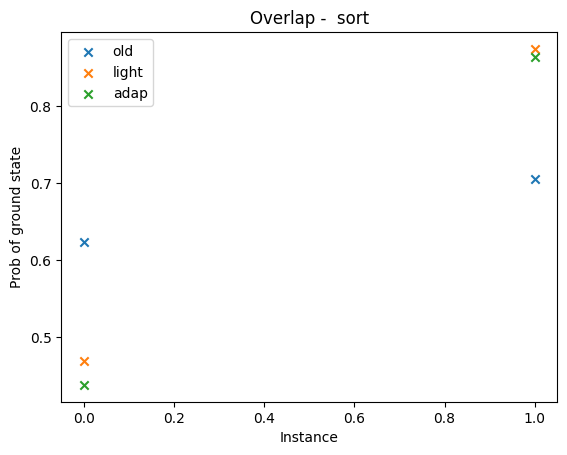

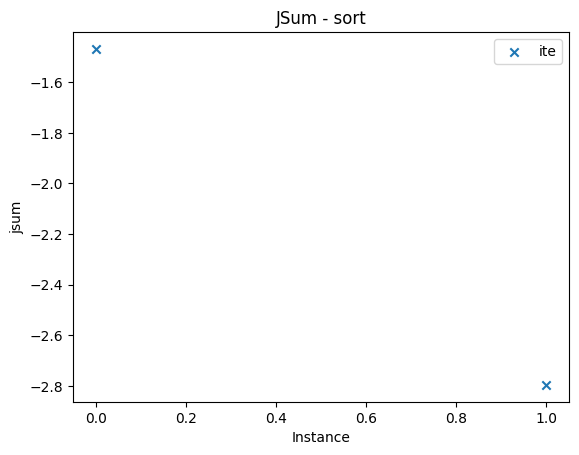

In [176]:
#ABS SORT 
# Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 2
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs_abs = np.abs(edge_coeffs)
    sorted_ind = np.argsort(edge_coeffs_abs)
    # edge_coeffs = np.sort(edge_coeffs)
    edge_coeffs = edge_coeffs[sorted_ind]
    edge_coeffs = edge_coeffs[::-1]
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()





#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.88383278  0.73235229  0.20223002  0.41614516 -0.95883101  0.9398197
  0.66488528 -0.57532178 -0.63635007 -0.63319098 -0.39151551  0.04951286
 -0.13610996 -0.41754172  0.22370579]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [-0.8838327756636011, 0.7323522915498704, 0.2022300234864176] 0.05074953937268689 1.818415090699889 
 col:  1 [0.416145155592091, -0.9588310114083951] -0.5426858558163041 1.374976167000486 
 col:  2 [0.9398197043239886, 0.6648852816008435, -0.5753217786434477] 1.0293832072813844 2.1800267645682796 
 col:  3 [-0.6363500655857988, -0.6331909802931324] -1.2695410458789311 1.2695410458789311 
 col:  4 [-0.39151551408092455, 0.04951286326447568, -0.13610996271576847] -0.47811261353221735 0.5771383400611687 
 col:  5 [-0.4175417196039162, 0.22370578944475894] -0.19383593015915723 0.6412475090486751 

~~~~

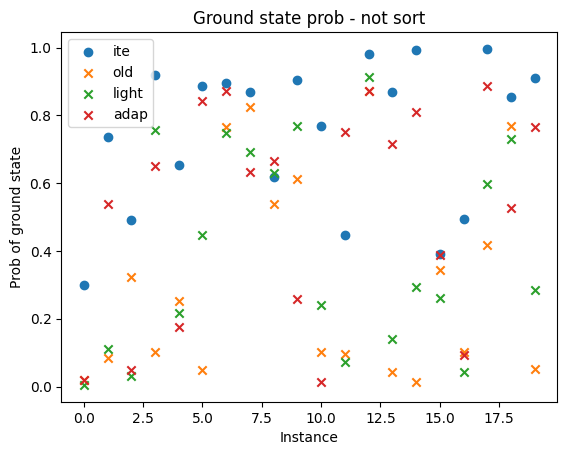

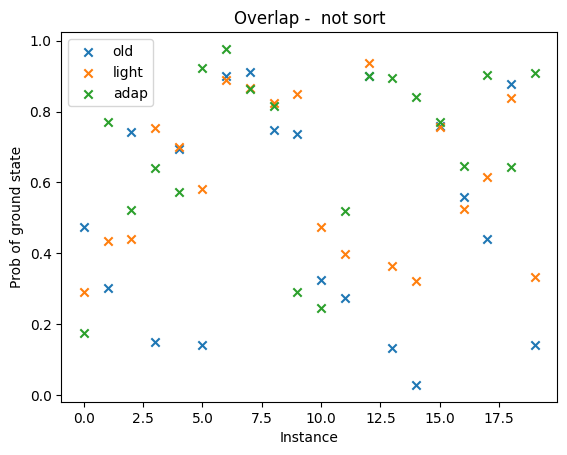

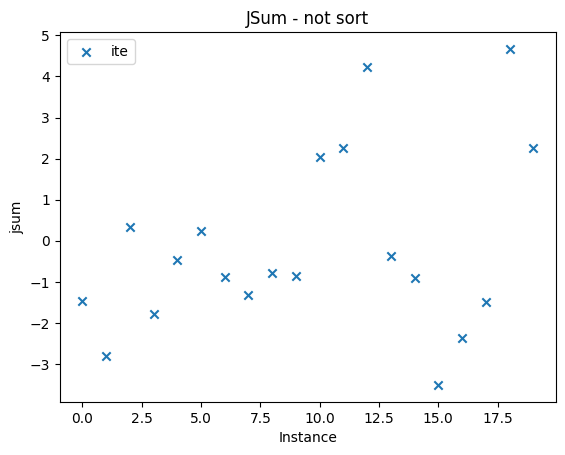

In [177]:
#  Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 20
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    # edge_coeffs = np.sort(edge_coeffs)
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - not sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap -  not sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - not sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()





#############################################################################
tau: 1
[ 0.9398197   0.90142861  0.73235229  0.66488528  0.46398788  0.41614516
  0.22370579  0.20223002  0.19731697  0.04951286 -0.13610996 -0.25091976
 -0.39151551 -0.41754172 -0.57532178 -0.63319098 -0.63635007 -0.68796272
 -0.68801096 -0.88383278 -0.95883101]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [0.22370578944475894, 0.2022300234864176, 0.1973169683940732] 0.6232527813252497 0.6232527813252497 
 col:  1 [0.04951286326447568, -0.13610996271576847] -0.08659709945129279 0.18562282598024415 
 col:  2 [-0.250919762305275, -0.39151551408092455, -0.4175417196039162] -1.0599769959901157 1.0599769959901157 
 col:  3 [-0.5753217786434477, -0.6331909802931324] -1.20851275893658 1.20851275893658 
 col:  4 [-0.6363500655857988, -0.687962719115127, -0.6880109593275947] -2.0123237440285204 2.0123237440285204 
 col:  5 [-0.8838327756636011, -0.9588310114083951] -1.8426637870719962 1.8426637870719962 

~~~

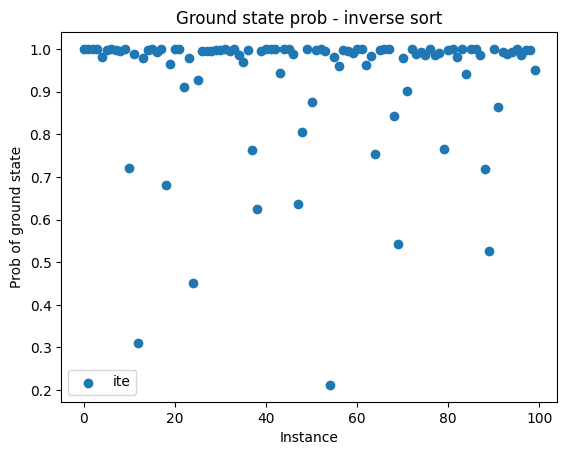

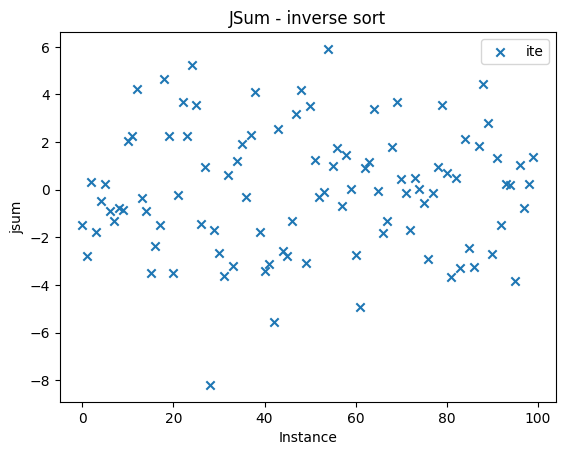

In [164]:
#ALL INVERSE
#  Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 100
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = []

for trial in range(ntrials):
    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    coeff_list = np.concatenate((node_list, edge_coeffs))
    coeff_list = np.sort(coeff_list)[::-1]
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    # Ampth = 0.0 
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # oldp.append(list(exp_poss_dict.items())[0][1])
    # oldov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # lightp.append(list(exp_poss_dict.items())[0][1])
    # lightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), oldov, label='old', marker='x')
# plt.scatter( range(ntrials), lightov, label='light', marker='x')
# plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("Overlap - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("Prob of ground state")
# plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - inverse sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()


for ind, prob in enumerate(itep):
    if prob < 0.9:
        print('prob and sum for bad cases', prob, csumlist[ind])

for ind, prob in enumerate(itep):
    if prob > 0.9:
        print('prob and sum for good cases', prob, csumlist[ind])

print("\n",len([x for x in itep if x > 0.9]))



#############################################################################
tau: 1
[ 0.9398197   0.90142861  0.73235229  0.66488528  0.46398788  0.41614516
  0.22370579  0.20223002  0.19731697  0.04951286 -0.13610996 -0.25091976
 -0.39151551 -0.41754172 -0.57532178 -0.63319098 -0.63635007 -0.68796272
 -0.68801096 -0.88383278 -0.95883101]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [0.22370578944475894, 0.2022300234864176, 0.1973169683940732] 0.6232527813252497 0.6232527813252497 
 col:  1 [0.04951286326447568, -0.13610996271576847] -0.08659709945129279 0.18562282598024415 
 col:  2 [-0.250919762305275, -0.39151551408092455, -0.4175417196039162] -1.0599769959901157 1.0599769959901157 
 col:  3 [-0.5753217786434477, -0.6331909802931324] -1.20851275893658 1.20851275893658 
 col:  4 [-0.6363500655857988, -0.687962719115127, -0.6880109593275947] -2.0123237440285204 2.0123237440285204 
 col:  5 [-0.8838327756636011, -0.9588310114083951] -1.8426637870719962 1.8426637870719962 

~~~

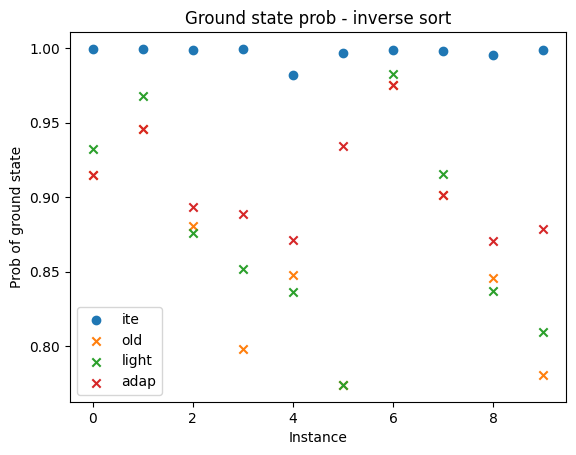

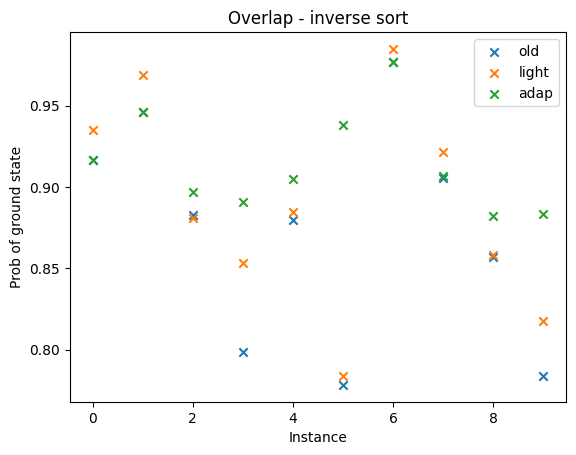

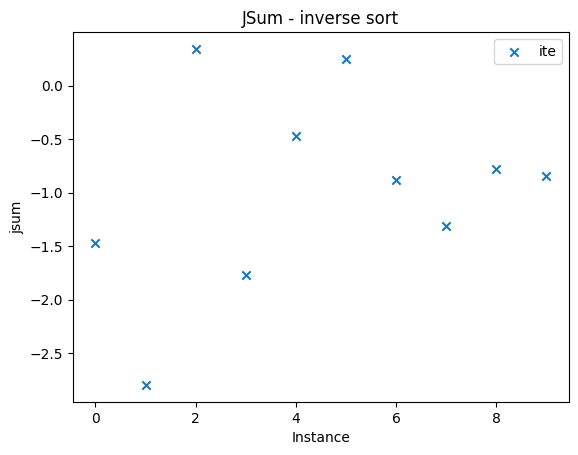

In [165]:
#ALL INVERSE
#  Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 10
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = []

for trial in range(ntrials):
    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    coeff_list = np.concatenate((node_list, edge_coeffs))
    coeff_list = np.sort(coeff_list)[::-1]
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - inverse sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()


for ind, prob in enumerate(itep):
    if prob < 0.9:
        print('prob and sum for bad cases', prob, csumlist[ind])

for ind, prob in enumerate(itep):
    if prob > 0.9:
        print('prob and sum for good cases', prob, csumlist[ind])

print("\n",len([x for x in itep if x > 0.9]))



#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  0.9398197   0.73235229  0.66488528  0.41614516  0.22370579  0.20223002
  0.04951286 -0.13610996 -0.39151551 -0.41754172 -0.57532178 -0.63319098
 -0.63635007 -0.88383278 -0.95883101]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [0.9398197043239886, 0.7323522915498704, 0.6648852816008435] 2.3370572774747025 2.3370572774747025 
 col:  1 [0.416145155592091, 0.22370578944475894] 0.6398509450368499 0.6398509450368499 
 col:  2 [0.2022300234864176, 0.04951286326447568, -0.13610996271576847] 0.11563292403512482 0.38785284946666176 
 col:  3 [-0.39151551408092455, -0.4175417196039162] -0.8090572336848407 0.8090572336848407 
 col:  4 [-0.5753217786434477, -0.6331909802931324, -0.6363500655857988] -1.8448628245223788 1.8448628245223788 
 col:  5 [-0.8838327756636011, -0.9588310114083951] -1.8426637870719962 1.8426637870719962 

~~~

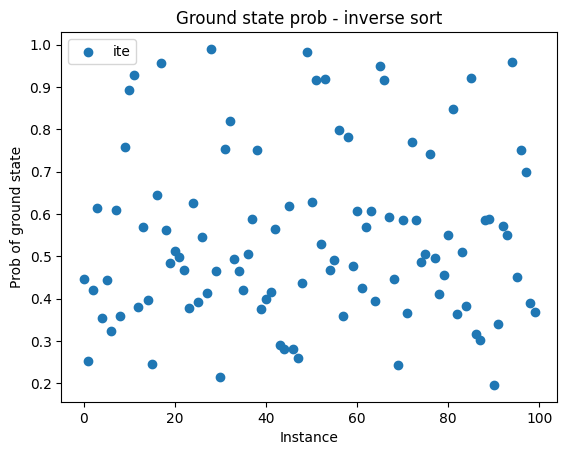

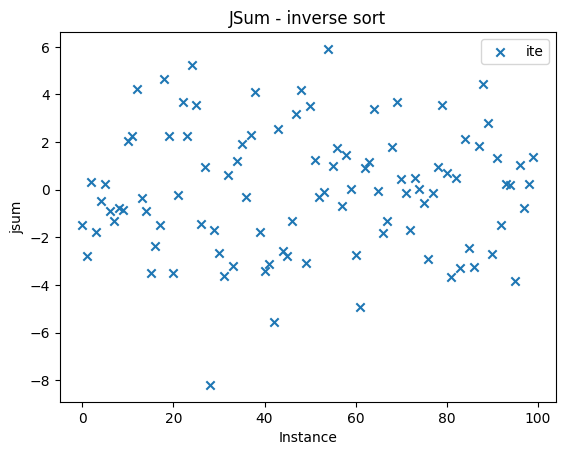

In [ ]:
# Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 100
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = []

for trial in range(ntrials):
    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs = np.sort(edge_coeffs)[::-1]
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    # Ampth = 0.0 
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # oldp.append(list(exp_poss_dict.items())[0][1])
    # oldov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # lightp.append(list(exp_poss_dict.items())[0][1])
    # lightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - inverse sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), oldov, label='old', marker='x')
# plt.scatter( range(ntrials), lightov, label='light', marker='x')
# plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("Overlap - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("Prob of ground state")
# plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - inverse sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()


for ind, prob in enumerate(itep):
    if prob < 0.9:
        print('prob and sum for bad cases', prob, csumlist[ind])

for ind, prob in enumerate(itep):
    if prob > 0.9:
        print('prob and sum for good cases', prob, csumlist[ind])

print("\n",len([x for x in itep if x > 0.9]))



#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.95883101 -0.88383278 -0.63635007 -0.63319098 -0.57532178 -0.41754172
 -0.39151551 -0.13610996  0.04951286  0.20223002  0.22370579  0.41614516
  0.66488528  0.73235229  0.9398197 ]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [-0.9588310114083951, -0.8838327756636011, -0.6363500655857988] -2.479013852657795 2.479013852657795 
 col:  1 [-0.6331909802931324, -0.5753217786434477] -1.20851275893658 1.20851275893658 
 col:  2 [-0.4175417196039162, -0.39151551408092455, -0.13610996271576847] -0.9451671964006092 0.9451671964006092 
 col:  3 [0.04951286326447568, 0.2022300234864176] 0.2517428867508933 0.2517428867508933 
 col:  4 [0.22370578944475894, 0.416145155592091, 0.6648852816008435] 1.3047362266376934 1.3047362266376934 
 col:  5 [0.7323522915498704, 0.9398197043239886] 1.672171995873859 1.672171995873859 

~~~~~~~~~~~~~

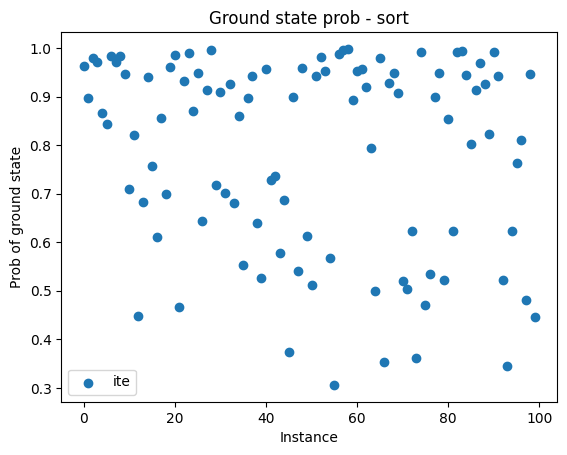

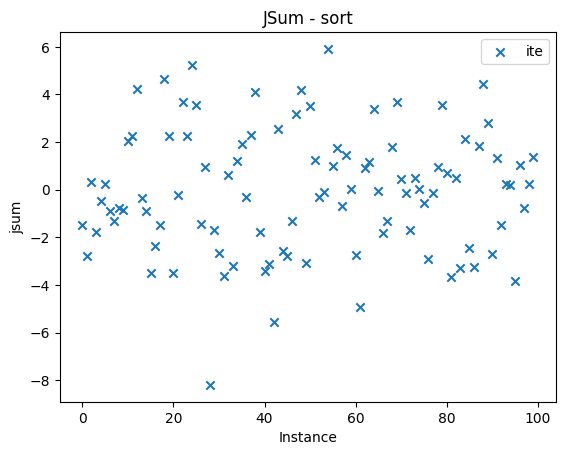

In [ ]:
# Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 100
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = []

for trial in range(ntrials):
    node_list = np.random.uniform(-1, 1, N)
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs = np.sort(edge_coeffs)
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    # Ampth = 0.0 
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # oldp.append(list(exp_poss_dict.items())[0][1])
    # oldov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # lightp.append(list(exp_poss_dict.items())[0][1])
    # lightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), oldov, label='old', marker='x')
# plt.scatter( range(ntrials), lightov, label='light', marker='x')
# plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("Overlap - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("Prob of ground state")
# plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()

print("\n",len([x for x in itep if x > 0.9]))



#############################################################################
tau: 1
[1 1 1 1 2 0]
6
0 check

coeff sum 6
 col:  0 [1] 1 1 
 col:  1 [2] 2 2 
 col:  2 [0] 0 0 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE
exp_poss_dict (-4.0, 0.9637218364320066)
prob and sum for good cases 0.9637218364320066 6

 1


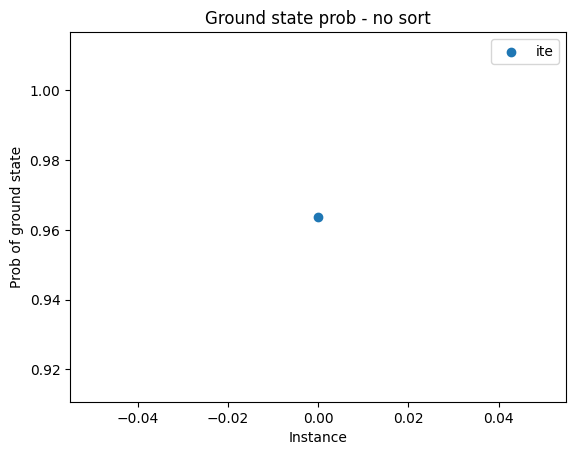

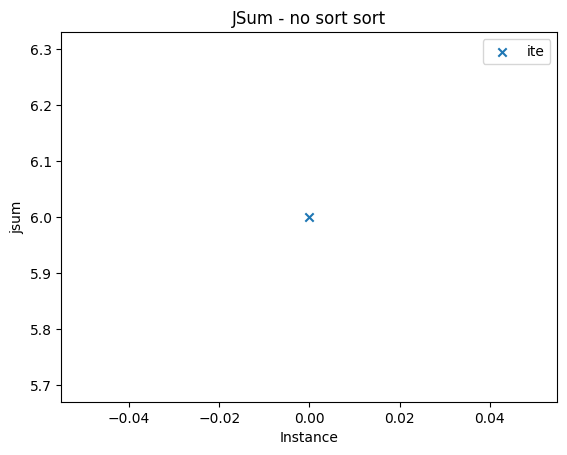

In [181]:
# Set the seed
np.random.seed(42)

N = 3
tau = 1
Numpara = 2

ntrials = 1
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = []

for trial in range(ntrials):
    # node_list = np.random.uniform(-1, 1, N) 
    node_list = np.array([1,1,1])
    # edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs = np.array([1,2,0])
    # edge_coeffs = np.sort(edge_coeffs)[::-1]
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    # Ampth = 0.0 
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # oldp.append(list(exp_poss_dict.items())[0][1])
    # oldov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # lightp.append(list(exp_poss_dict.items())[0][1])
    # lightov.append(abs(np.dot(state_ite, state_all))**2)

    # print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    # Ampth = 0.95
    # edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # # print('edge_params_dict', edge_params_dict)
    # print('exp_poss_dict', list(exp_poss_dict.items())[0])
    # print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    # adapp.append(list(exp_poss_dict.items())[0][1])
    # adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob - no sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# # Step 3: Plot the sorted lists
# plt.figure()
# plt.scatter( range(ntrials), oldov, label='old', marker='x')
# plt.scatter( range(ntrials), lightov, label='light', marker='x')
# plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# # Add title, labels, and legend
# plt.title("Overlap - inverse sort")
# plt.xlabel("Instance")
# plt.ylabel("Prob of ground state")
# plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - no sort sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()


for ind, prob in enumerate(itep):
    if prob < 0.9:
        print('prob and sum for bad cases', prob, csumlist[ind])

for ind, prob in enumerate(itep):
    if prob > 0.9:
        print('prob and sum for good cases', prob, csumlist[ind])

print("\n",len([x for x in itep if x > 0.9]))

In [190]:
#SPECTRAL GAP
print("SPECTRAL GAP\n")
# # Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 5
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    # edge_coeffs = np.sort(edge_coeffs)
    coeff_list = np.concatenate((node_list, edge_coeffs))
    coeff_list = np.sort(coeff_list)[::-1]
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    eigen_sorted = np.sort(eigen_list)
    print('spectral gap', eigen_sorted[1]- eigen_sorted[0])
    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])



SPECTRAL GAP



#############################################################################
tau: 1
[ 0.9398197   0.90142861  0.73235229  0.66488528  0.46398788  0.41614516
  0.22370579  0.20223002  0.19731697  0.04951286 -0.13610996 -0.25091976
 -0.39151551 -0.41754172 -0.57532178 -0.63319098 -0.63635007 -0.68796272
 -0.68801096 -0.88383278 -0.95883101]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [0.22370578944475894, 0.2022300234864176, 0.1973169683940732] 0.6232527813252497 0.6232527813252497 
 col:  1 [0.04951286326447568, -0.13610996271576847] -0.08659709945129279 0.18562282598024415 
 col:  2 [-0.250919762305275, -0.39151551408092455, -0.4175417196039162] -1.0599769959901157 1.0599769959901157 
 col:  3 [-0.5753217786434477, -0.6331909802931324] -1.20851275893658 1.20851275893658 
 col:  4 [-0.6363500655857988, -0.687962719115127, -0.6880109593275947] -2.0123237440285204 2.0123237440285204 
 col:  5 [-0.8838327756636011, -0.9588310114083951] -1.8426637870719962 1.84266378



#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.95883101 -0.88383278 -0.63635007 -0.63319098 -0.57532178 -0.41754172
 -0.39151551 -0.13610996  0.04951286  0.20223002  0.22370579  0.41614516
  0.66488528  0.73235229  0.9398197 ]
21
0 check

coeff sum -1.4682026746438195
 col:  0 [-0.9588310114083951, -0.8838327756636011, -0.6363500655857988] -2.479013852657795 2.479013852657795 
 col:  1 [-0.6331909802931324, -0.5753217786434477] -1.20851275893658 1.20851275893658 
 col:  2 [-0.4175417196039162, -0.39151551408092455, -0.13610996271576847] -0.9451671964006092 0.9451671964006092 
 col:  3 [0.04951286326447568, 0.2022300234864176] 0.2517428867508933 0.2517428867508933 
 col:  4 [0.22370578944475894, 0.416145155592091, 0.6648852816008435] 1.3047362266376934 1.3047362266376934 
 col:  5 [0.7323522915498704, 0.9398197043239886] 1.672171995873859 1.672171995873859 

~~~~~~~~~~~~~

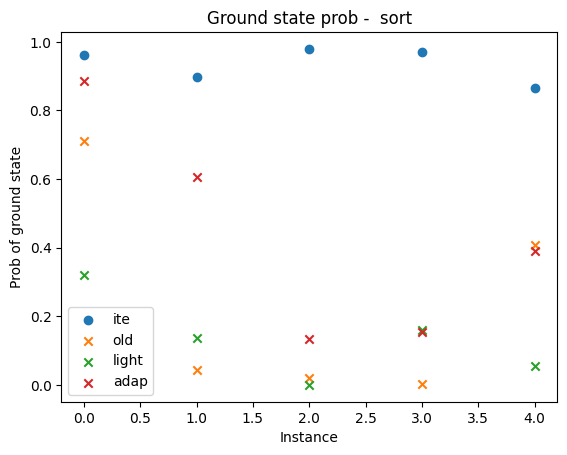

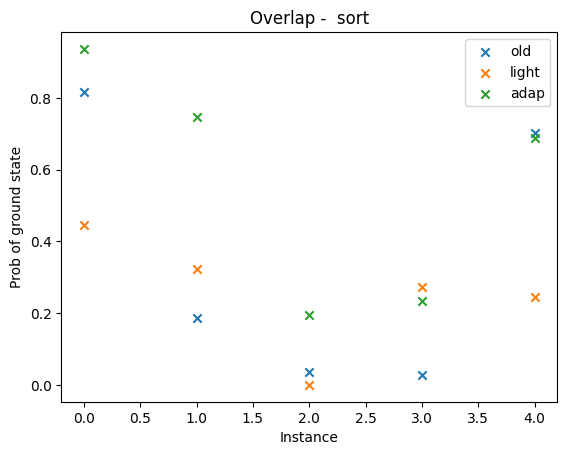

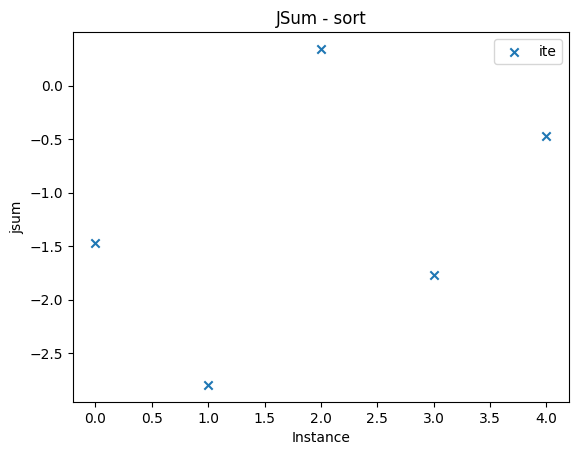

In [157]:
# PARAM INIT TO PI/2!!!!!!!!!!!
#  Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 5
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))
    edge_coeffs = np.sort(edge_coeffs)
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()





#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
 -0.95883101 -0.88383278 -0.63635007 -0.63319098 -0.57532178 -0.41754172
 -0.39151551  0.9398197   0.73235229  0.66488528  0.41614516  0.22370579
  0.20223002  0.04951286 -0.13610996]
21
0 check

coeff sum -1.4682026746438193
 col:  0 [-0.9588310114083951, -0.8838327756636011, -0.6363500655857988] -2.479013852657795 2.479013852657795 
 col:  1 [-0.6331909802931324, -0.5753217786434477] -1.20851275893658 1.20851275893658 
 col:  2 [-0.4175417196039162, -0.39151551408092455, 0.9398197043239886] 0.13076247063914792 1.7488769380088294 
 col:  3 [0.7323522915498704, 0.6648852816008435] 1.3972375731507138 1.3972375731507138 
 col:  4 [0.416145155592091, 0.22370578944475894, 0.2022300234864176] 0.8420809685232675 0.8420809685232675 
 col:  5 [0.04951286326447568, -0.13610996271576847] -0.08659709945129279 0.18562282598024415 

~~~~~~~~

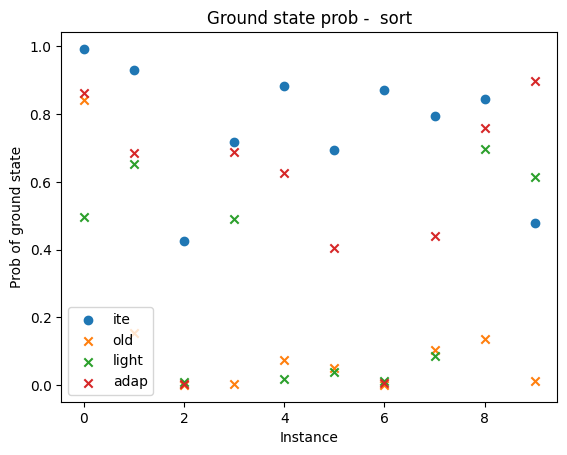

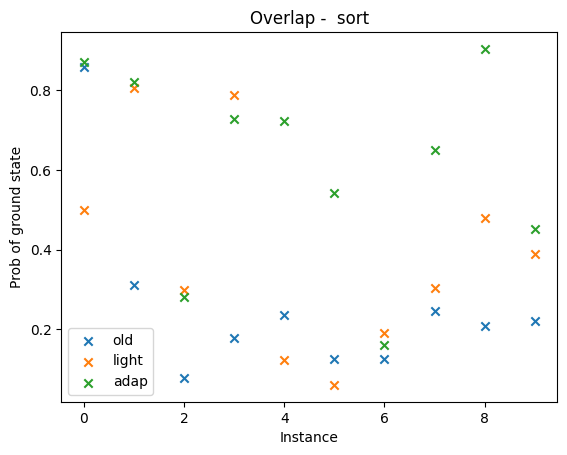

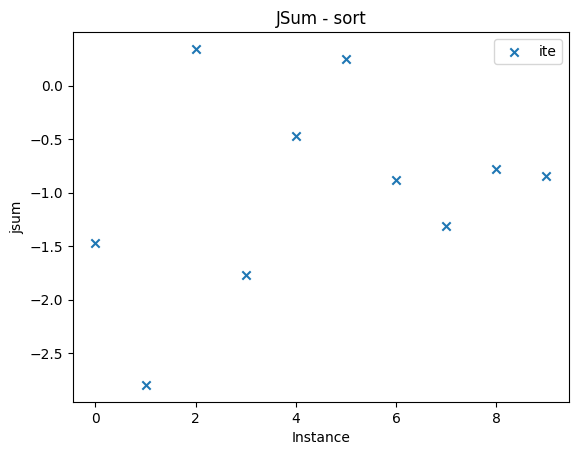

In [173]:
#LARGEST IN THE MIDDLE

#   Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 10
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))

    # Step 1: Sort the array in ascending order
    edge_coeffs = np.sort(edge_coeffs)
    
    # Step 2: Find the middle index
    mid = len(edge_coeffs) // 2
    
    # Step 3: Split into two parts
    first_half = edge_coeffs[:mid]
    second_half = edge_coeffs[mid:]
    
    # Step 4: Reverse the second half
    second_half = second_half[::-1]
    
    # Step 5: Concatenate the two halves
    edge_coeffs = np.concatenate((first_half, second_half))
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()





#############################################################################
tau: 1
[-0.25091976  0.90142861  0.46398788  0.19731697 -0.68796272 -0.68801096
  0.9398197   0.73235229  0.66488528  0.41614516  0.22370579  0.20223002
  0.04951286 -0.95883101 -0.88383278 -0.63635007 -0.63319098 -0.57532178
 -0.41754172 -0.39151551 -0.13610996]
21
0 check

coeff sum -1.4682026746438188
 col:  0 [0.9398197043239886, 0.7323522915498704, 0.6648852816008435] 2.3370572774747025 2.3370572774747025 
 col:  1 [0.416145155592091, 0.22370578944475894] 0.6398509450368499 0.6398509450368499 
 col:  2 [0.2022300234864176, 0.04951286326447568, -0.9588310114083951] -0.7070881246575018 1.2105738981592884 
 col:  3 [-0.8838327756636011, -0.6363500655857988] -1.5201828412493998 1.5201828412493998 
 col:  4 [-0.6331909802931324, -0.5753217786434477, -0.4175417196039162] -1.6260544785404962 1.6260544785404962 
 col:  5 [-0.39151551408092455, -0.13610996271576847] -0.527625476796693 0.527625476796693 

~~~~~~

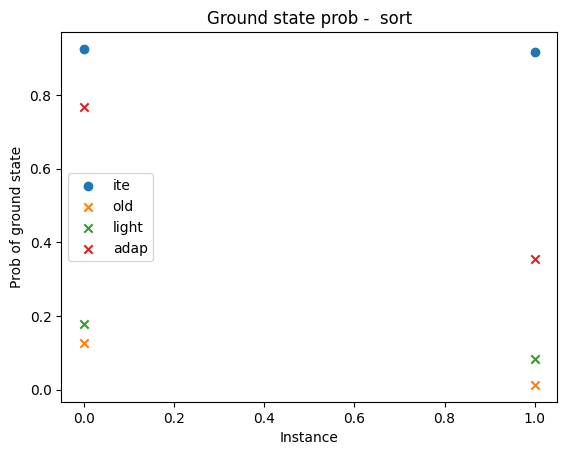

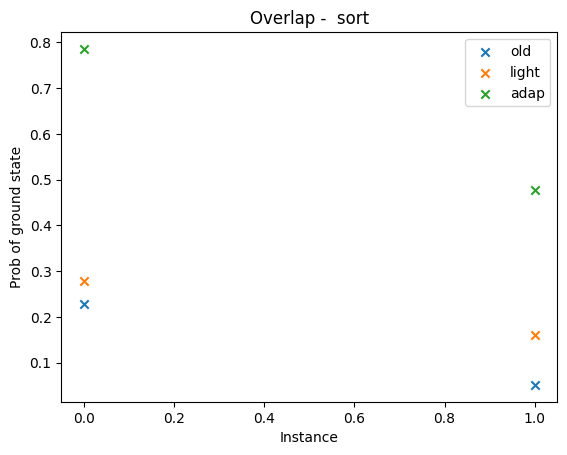

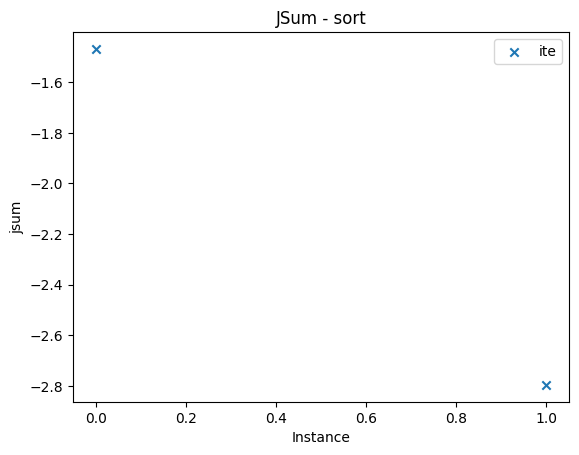

In [163]:
#LARGEST IN THE MIDDLE INVERSE
#  Set the seed
np.random.seed(42)

N = 6
tau = 1
Numpara = 2

ntrials = 2
print('\n\n#############################################################################')
print('tau:', tau)

G = nx.complete_graph(N)
# coeff_list = np.random.uniform(-0.45, -0.55, N)
# for column_index, column in enumerate(edges_columns):
#     if column_index == 0:
#         edge_coeffs = np.random.uniform(0.9, 1, len(column))
#     else:
#         edge_coeffs = np.random.uniform(-0.45, -0.55, len(column))
#     coeff_list = np.concatenate((coeff_list, edge_coeffs))

itep = []
oldp = []
oldov = []
lightp = []
lightov = []
adapp = []
adapov = []
csumlist = [] 

for trial in range(ntrials):
    # coeff_list = np.random.uniform(-1, 1, len(G.edges()) + N)
    # coeff_list = np.sort(coeff_list)[::-1]
    # print(coeff_list)
    # print(len(coeff_list))
    # print(len(G.edges()) + N - len(coeff_list), "check")

    node_list = np.random.uniform(-1, 1, N) 
    edge_coeffs = np.random.uniform(-1, 1, len(G.edges()))

    # Step 1: Sort the array in ascending order
    edge_coeffs = np.sort(edge_coeffs)[::-1]
    
    # Step 2: Find the middle index
    mid = len(edge_coeffs) // 2
    
    # Step 3: Split into two parts
    first_half = edge_coeffs[:mid]
    second_half = edge_coeffs[mid:]
    
    # Step 4: Reverse the second half
    second_half = second_half[::-1]
    
    # Step 5: Concatenate the two halves
    edge_coeffs = np.concatenate((first_half, second_half))
    coeff_list = np.concatenate((node_list, edge_coeffs))
    print(coeff_list)
    print(len(coeff_list))
    print(len(G.edges()) + N - len(coeff_list), "check")
    
    h_list = coeff_list[: N ]
    J_list = coeff_list[N :]

    csum = np.sum(coeff_list)
    print('\ncoeff sum',csum)
    csumlist.append(csum)

    edges_columns = partition_N(N)
    lightcone_dict = find_light_cone(edges_columns)
    pairs_all = list(itertools.chain.from_iterable(partition_N(N)))

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    #extrcact Hamiltonian, edge coefficients and eigen list
    H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
    eigen_list = H.to_spmatrix().diagonal().real


    # Initialize dictionary for single Pauli Z term with coefficient from h_list
    edge_coeff_dict = {}
    edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
    #Initialize dictionary for Pauli ZZ term with coefficient from from J_list

    #CAMBIO GLI ARGOMENTI DELL' HAMILTONIANA PER AVERE COEFFICIENTI SCRITTI PIU' FRIENDLY
    edge_coeff_dict.update({edge: J_val for edge, J_val in zip(pairs_all, J_list)})

    # Print lists with different colors based on the condition
    for column_index, column in enumerate(edges_columns):
        toprint = []
        sum_j = 0 
        abs_sum_j = 0
        for edge in column:
            toprint.append(edge_coeff_dict[edge])  
            sum_j += edge_coeff_dict[edge]
            abs_sum_j += abs(edge_coeff_dict[edge])
        print(RED, 'col: ', column_index, toprint, sum_j, abs_sum_j, RESET)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ITE')
    exp_poss_dict, state_ite = ITE(N, edge_coeff_dict, tau, eigen_list)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    itep.append(list(exp_poss_dict.items())[0][1])

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start old')
    Ampth = 0.0 
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    oldp.append(list(exp_poss_dict.items())[0][1])
    oldov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start lightcone')
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    lightp.append(list(exp_poss_dict.items())[0][1])
    lightov.append(abs(np.dot(state_ite, state_all))**2)

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Warm start adaptive lightcone')
    Ampth = 0.95
    edge_params_dict, params_init, exp_poss_dict, state_all = warm_start_parameters_adaptlightcone(N, tau, Numpara, Ampth, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
    # print('edge_params_dict', edge_params_dict)
    print('exp_poss_dict', list(exp_poss_dict.items())[0])
    print('overlap btw ite and opt state', abs(np.dot(state_ite, state_all))**2)
    adapp.append(list(exp_poss_dict.items())[0][1])
    adapov.append(abs(np.dot(state_ite, state_all))**2)

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), itep, label='ite', marker='o')
plt.scatter( range(ntrials), oldp, label='old', marker='x')
plt.scatter( range(ntrials), lightp, label='light', marker='x')
plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Ground state prob -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), oldov, label='old', marker='x')
plt.scatter( range(ntrials), lightov, label='light', marker='x')
plt.scatter(range(ntrials), adapov, label='adap', marker='x')

# Add title, labels, and legend
plt.title("Overlap -  sort")
plt.xlabel("Instance")
plt.ylabel("Prob of ground state")
plt.legend()

# Step 3: Plot the sorted lists
plt.figure()
plt.scatter( range(ntrials), csumlist, label='ite', marker='x')
# plt.scatter( range(ntrials), oldp, label='old', marker='x')
# plt.scatter( range(ntrials), lightp, label='light', marker='x')
# plt.scatter(range(ntrials), adapp, label='adap', marker='x')

# Add title, labels, and legend
plt.title("JSum - sort")
plt.xlabel("Instance")
plt.ylabel("jsum")
plt.legend()



In [ ]:
print(edge_list)
print(pairs_all)
print(edges_columns)

[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (1, 2), (1, 3), (1, 4), (1, 5), (2, 3), (2, 4), (2, 5), (3, 4), (3, 5), (4, 5)]
[(0, 1), (2, 3), (4, 5), (0, 3), (2, 5), (1, 3), (0, 5), (2, 4), (1, 5), (0, 4), (3, 5), (1, 4), (0, 2), (3, 4), (1, 2)]
[[(0, 1), (2, 3), (4, 5)], [(0, 3), (2, 5)], [(1, 3), (0, 5), (2, 4)], [(1, 5), (0, 4)], [(3, 5), (1, 4), (0, 2)], [(3, 4), (1, 2)]]


In [ ]:
print(ite)
print(old)
print(light)
print(adap)

NameError: name 'ite' is not defined

initialization warm_start_measure
old 0.7342849006079925
old 0.7624639106436925
old 0.029748110102140537
old 0.14545431915280949
old 0.07751845301121918
old 0.20337098366372836
old 0.7431152519830552
old 0.4684905907212423
old 0.20651989696255563
old 0.2633626992764105
initialization warm_start_measure_lightcone


FileNotFoundError: [Errno 2] No such file or directory: './data/ansatz_type_structure_like_qubo_YZ_2/shots_None/num_variables_006/params_36_layer_1/alpha_0.01/initial_warm_start_measure_lightcone/r_0/tau_1.0.pkl'

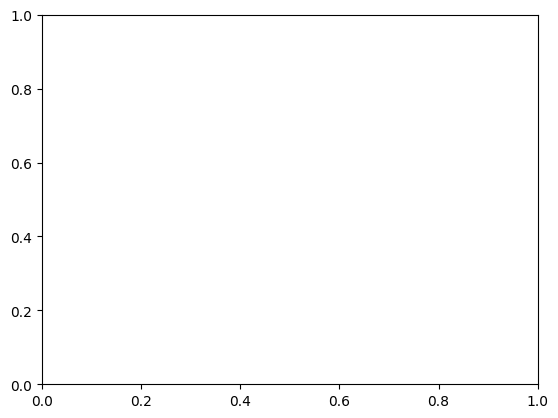

In [ ]:
import matplotlib.pyplot as plt

num_variables_list = [str(num).zfill(3) for num in range(6,8, 2)]

N_ins = 10 ###100 50 number of random instances

# initialization =  'warm_start_measure' #'random' or 'zeros' or 'warm_start_measure'

ansatz_type = 'structure_like_qubo_YZ_2' #'R_y' or 'structure_like_qubo_YZ_2'

layer = 1

shots = None

alpha = 0.01

dir_0 = './data' + '/ansatz_type_{}/shots_{}'\
                        .format(ansatz_type,  shots)


y_qubits = []

fig4, ax4 = plt.subplots()

tau =1.0

for num_variables in num_variables_list:

    n_qubits = int(num_variables)

    pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
    num_pairs = len(pairs_all)
    num_params = (n_qubits + 2*num_pairs) * layer

    # # Create separate figures outside the inner loop
    # fig1, ax1 = plt.subplots()
    # fig2, ax2 = plt.subplots()
    # fig3, ax3 = plt.subplots()

    y_qubits = []

    for initialization in ['warm_start_measure', 'warm_start_measure_lightcone']:
        
        # if initialization == 'warm_start_measure_lightcone':
        #     tau = str(tau) + "_random"

        print('initialization', initialization) 
        y = []

        dir_name =  dir_0 + '/num_variables_{}/params_{}_layer_{}/alpha_{}/initial_{}'\
                            .format(num_variables, num_params, layer, alpha, initialization)
        
        for r in range(N_ins):
                
            file_dir_name = dir_name + '/r_{}'\
                            .format(r)
            
            if initialization ==  'warm_start_measure':
                file_path = file_dir_name + '/tau_{}.pkl'\
                                            .format(tau)
                # Open the .pkl file in read mode
                with open(file_path, 'rb') as f:
                    # Load the content of the file using pickle.load()
                    data = pickle.load(f)            
                fidelity = list(data['layers_exp_poss_dict']['l_1'].items())[0][1]
                print('old', fidelity)

            elif initialization == 'warm_start_measure_lightcone':
                file_path_lightcone = file_dir_name + '/tau_{}.pkl'\
                                                    .format(tau)
                #file_path_lightcone = file_dir_name + '/tau_{}_random.pkl'\
                                                    #.format(tau)

                
                # Open the .pkl file in read mode
                with open(file_path_lightcone, 'rb') as f:
                    # Load the content of the file using pickle.load()
                    data_lightcone = pickle.load(f)            
                fidelity = list(data_lightcone['exp_poss_dict'].items())[0][1]
                print('light', fidelity)

            else:
                sys.stderr.write('something is wrong with initialization')
                sys.exit()
            
            # print('fidelity', fidelity)

#             # x.append(n_qubits)
#             y.append(fidelity)

#         x = np.arange(N_ins)
#         print('x', x)

#         y = np.array(y)

#         ax1.scatter(x, y, marker='o', label = initialization)

#         # plt.plot( range(6,26,2), y2, '--', label = '1/2^N' , color = 'blue')
#         # plt.yscale('log')
#         ax1.set_title(f'Warm start fidelity, {num_variables} qubits')
#         ax1.set_xlabel('instance')
#         ax1.set_ylabel('fidelity')

#         # Display the legend
#         # plt.legend()
#         ax1.legend()
        
#         specific_dir_name =  dir_0 + '/num_variables_{}'\
#                             .format(num_variables, num_params, layer, alpha, initialization)
#         # Save the plot
#         fig1.savefig(specific_dir_name + '/warm_fidelity_tau{}.png'.format(tau))
#         #fig1.savefig(specific_dir_name + '/warm_fidelity_tau{}_random.png'.format(tau))
#         # plt.close()  # Close the figure

    
#         y2 = np.sort(y)

#         # plt.figure()
#         # plt.scatter(x, y, marker='o', label = initialization)

#         # # plt.plot( range(6,26,2), y2, '--', label = '1/2^N' , color = 'blue')
#         # # plt.yscale('log')
#         # plt.title(f'Warm start fidelity, {num_variables} qubits')
#         # plt.xlabel('instance')
#         # plt.ylabel('fidelity')

#         # # Display the legend
#         # plt.legend()

#         ax2.scatter(x, y2, marker='o', label = initialization)

#         # plt.plot( range(6,26,2), y2, '--', label = '1/2^N' , color = 'blue')
#         # plt.yscale('log')
#         ax2.set_title(f'Warm start fidelity, {num_variables} qubits')
#         ax2.set_xlabel('instance')
#         ax2.set_ylabel('fidelity')

#         # Display the legend
#         # plt.legend()
#         ax2.legend()
        

#         specific_dir_name =  dir_0 + '/num_variables_{}'\
#                             .format(num_variables)
#         # Save the plot
#         fig2.savefig(specific_dir_name + '/warm_fidelity_sorted_tau{}.png'.format(tau))
#         #fig2.savefig(specific_dir_name + '/warm_fidelity_sorted_tau{}_random.png'.format(tau))
#         # plt.close()  # Close the figure

#         if initialization == 'warm_start_measure' :
#             sorted_indices = np.argsort(y)                   #SORTED_2  

#         y3 = y[sorted_indices]

#         ax3.scatter(x, y3, marker='o', label = initialization)

#         # plt.plot( range(6,26,2), y2, '--', label = '1/2^N' , color = 'blue')
#         # plt.yscale('log')
#         ax3.set_title(f'Warm start fidelity, {num_variables} qubits')
#         ax3.set_xlabel('instance')
#         ax3.set_ylabel('fidelity')

#         # Display the legend
#         # plt.legend()
#         ax3.legend()
        
        
#         specific_dir_name =  dir_0 + '/num_variables_{}'\
#                             .format(num_variables, num_params, layer, alpha, initialization)
#         # Save the plot
#         fig3.savefig(specific_dir_name + '/warm_fidelity_sorted_2_tau{}.png'.format(tau))
#         #fig3.savefig(specific_dir_name + '/warm_fidelity_sorted_2_tau{}_random.png'.format(tau))
#         # plt.close()  # Close the figure

        
#         y4 = [1/(2**float(num_variables)) for X in x]
#         print('y4', y4)
        
#         print('x axis', x + 50*(float(num_variables)-6))

#         ax4.scatter(x + 50*(float(num_variables)-6), y2, marker='o', label = initialization)

#         ax4.plot( x + 50*(float(num_variables)-6), y4, '--' , color = 'blue')
#         #ax4.set_yscale('log')
#         ax4.set_title(f'Warm start fidelity old vs new, all qubits, tau: {tau}')
#         ax4.set_xlabel('N qubits')
#         ax4.set_ylabel('fidelity')
#         #ax4.set_ylabel('fidelity log')

#         # Display the legend
#         #plt.legend()
#         #ax4.legend()
         
#         # Save the plot
#         #fig4.savefig(dir_0 + '/warm_fidelity_sorted_2_qubits_log_tau{}.png'.format(tau))
#         fig4.savefig(dir_0 + '/warm_fidelity_sorted_2_qubits_tau{}.png'.format(tau))
#         #fig4.savefig(dir_0 + '/warm_fidelity_sorted_2_qubits_tau{}_random.png'.format(tau))
#         # plt.close()  # Close the figure
    
#     # Close the figures after the loop
#     plt.close(fig1)
#     plt.close(fig2)
#     plt.close(fig3)

# plt.close(fig4)
    

In [ ]:
def circuit_update_theta_Yahui(Edge, Circ, paras):

    qcirc = Circ.copy()
    
    i = min(Edge)
    j = max(Edge)

    ### exp{-i/2 ( params[2]*ZiYj + params[3]*YiZj )}
    qcirc.rx(-np.pi/2, i)
    qcirc.rz(-np.pi/2, j)

    qcirc.cx(i, j)
    qcirc.ry(paras[0], i)
    qcirc.rz(-paras[1], j)
    qcirc.cx(i, j)

    qcirc.rx(np.pi/2, i)
    qcirc.rz(np.pi/2, j)
    
    State = Statevector(qcirc)

    # print('states2 yahui', State)

    return State

def square_modulus_cost(Paras : list, *args):

    Edge = args[0]
    State = args[1]
    Tauc = args[2]
    N = args[3]

    State_zz = circuit_update_zz(Edge,State, Tauc, N)
    State_theta = circuit_update_theta(Edge,State, Paras, N)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State_theta)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    # print("Square modulus of the inner product:", square_modulus)

    return - square_modulus

def square_modulus_cost_Yahui(Paras : list, *args):

    Edge = args[0]
    Circ = args[1]
    Tauc = args[2]
    N = args[3]

    State =  Statevector(Circ)

    State_zz = circuit_update_zz(Edge,State, Tauc, N)
    State_theta = circuit_update_theta_Yahui(Edge, Circ, Paras)

    # Compute the scalar product (inner product) between the two state vectors
    inner_product = State_zz.inner(State_theta)

    # Compute the square modulus of the inner product
    square_modulus = abs(inner_product)**2

    # Print the inner product and its square modulus
    # print("Inner product:", inner_product)
    print("Square modulus of the inner product:", square_modulus)

    return - square_modulus

In [ ]:
# def warm_start_parameters_lightcone(N : int, tau:float, edge_coeff_dict : dict, edges_columns :list, lightcone_dict: dict):    
    
#     edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer

#     q = QuantumRegister(N, name = 'q')
#     circ = QuantumCircuit(q)
#     circ.clear()
#     circ.h(q[::])

#     tau = 0.2

#     # Z term
#     for i in range(N):

#         #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
#         tauc = tau * edge_coeff_dict[(i,)] 
#         para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)
#         edge_params_dict[(i,)] = para
#         circ.ry(para, i)
        
#     ## ZZ term 
#     state = Statevector(circ)
#     updated_state = state 

#     print('\nnumber of columns is:', len(edges_columns))

#     for column_index, column in enumerate(edges_columns):
#         print('\n##################################################')
#         print('column index', column_index, 'column', column)

#         if column_index == 0: 

#             first_column_state = state

#             for edge in column:
                
#                 if len(lightcone_dict[edge]) != 0:
#                     sys.stderr.write('something is wrong with the lightcones')
#                     sys.exit()
            
#                 print('\nedge', edge)  

#                 tauc = tau * edge_coeff_dict[edge]

#                 para_init = [0,0]

#                 final = minimize(square_modulus_cost,
#                                     para_init,
#                                     args = (edge, first_column_state, tauc),
#                                     jac=False,
#                                     bounds=None,
#                                     method='L-BFGS-B',
#                                     callback=None,
#                                     options={'maxiter': 100})

#                 para = final.x

#                 print('opt paramenters', para)
#                 print('final square modulus', final.fun)

#                 edge_params_dict[edge] = para
#                 print('edge_params_dict:', edge_params_dict)

#                 print('old state', state)
#                 first_column_state = circuit_update_theta(edge, first_column_state, para)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT

#                 print('first column state - new state', first_column_state)
            
#         else:
            
#             for edge in column: 
#                 if len(lightcone_dict[edge]) == 0:
#                         sys.stderr.write('something is wrong with the lightcones')
#                         sys.exit()

#                 print('\nedge', edge)  

#                 print('len light cone:', len(lightcone_dict[edge]), ', light cone edges:', lightcone_dict[edge])

#                 print('initial state', state)

#                 updated_state = copy.deepcopy(state)
                
#                 for old_edge in lightcone_dict[edge]:
#                     print('old_edge', old_edge, 'param', edge_params_dict[old_edge])
#                     updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge])    
                
#                 print('updated_state', updated_state)

#                 edge_list = lightcone_dict[edge] + [edge]
#                 print('edge list', edge_list)
                
#                 tauc = tau * edge_coeff_dict[edge]

#                 para_init = np.zeros(2 + 2*len(lightcone_dict[edge]))
#                 print('para init', para_init)

#                 final = minimize(square_modulus_cost_light_cone,
#                         para_init,
#                         args = (edge_list, state, tauc, updated_state),
#                         jac=False,
#                         bounds=None,
#                         method='L-BFGS-B',
#                         callback=None,
#                         options={'maxiter': 100})

#                 para = final.x
#                 print('opt paramenters', para)
#                 print('final square modulus', final.fun)

#                 para = (np.array(para)).reshape(-1, 2)
#                 print('param list reshaped', para)
#                 for index, edge in enumerate(edge_list):
#                     edge_params_dict[edge] = para[index] 
#                 print('edge_params_dict', edge_params_dict)
            
#             print('\n######### previous column update ########')
#             print('column index', column_index, 'column', column)
#             print('previous column is:', edges_columns[column_index -1])

#             for edge in edges_columns[column_index -1]:
#                 print('edge', edge, 'parameter', edge_params_dict[edge])
#                 state = circuit_update_theta(edge, state, edge_params_dict[edge])

#             print('circuit updated ad the previous column i.e. column', column_index -1)
#             print('updated statevector', state)

#     print('\n######### last column update ########')
#     print('last column is:', edges_columns[ -1])

#     for edge in edges_columns[ -1]:
#         print('edge', edge, 'parameter', edge_params_dict[edge])
#         state = circuit_update_theta(edge, state, edge_params_dict[edge])

#     print('circuit updated at the last column i.e.', len(edges_columns) - 1)
#     print('updated statevector', state)

#     #generate params_list
#     values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
#     # Concatenate and flatten all arrays into a single array
#     flattened_array = np.concatenate(values_as_arrays)
#     # Convert the flattened array to a list if needed
#     params_list = flattened_array.tolist()
#     print(' params_list' , params_list )

#     return edge_params_dict, params_list

In [ ]:
# Initialize dictionary for single Pauli Z term with coefficient from h_list
Edge_coeff_dict = {}
Edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
Edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
print('edge_coeff_dict' , Edge_coeff_dict)
#endregion

edge_coeff_dict {(0,): 0.1936, (1,): 0.5301, (2,): 0.8278, (3,): -0.8469, (4,): 0.1258, (5,): 0.9465, (0, 1): 0.8315, (0, 2): 0.6248, (0, 3): 0.4479, (0, 4): -0.6114, (0, 5): 0.3099, (1, 2): -0.454, (1, 3): -0.7734, (1, 4): 0.7477, (1, 5): 0.2512, (2, 3): 0.5387, (2, 4): -0.5476, (2, 5): 0.4688, (3, 4): -0.945, (3, 5): -0.7465, (4, 5): -0.7301}


In [ ]:
edge_params_dict, params_init, exp_poss_dict = warm_start_parameters_lightcone(N, tau, Edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)

state in Statevector([0.07900854+0.j, 0.0853701 +0.j, 0.09767015+0.j,
             0.10553429+0.j, 0.11002152+0.j, 0.11888016+0.j,
             0.13600831+0.j, 0.14695934+0.j, 0.05630571+0.j,
             0.0608393 +0.j, 0.06960497+0.j, 0.07520938+0.j,
             0.07840722+0.j, 0.08472036+0.j, 0.09692679+0.j,
             0.10473108+0.j, 0.08308598+0.j, 0.08977585+0.j,
             0.10271066+0.j, 0.11098066+0.j, 0.11569946+0.j,
             0.12501528+0.j, 0.14302736+0.j, 0.15454355+0.j,
             0.05921151+0.j, 0.06397907+0.j, 0.07319711+0.j,
             0.07909075+0.j, 0.08245362+0.j, 0.08909257+0.j,
             0.10192895+0.j, 0.110136  +0.j, 0.11537134+0.j,
             0.12466074+0.j, 0.14262174+0.j, 0.15410527+0.j,
             0.16065769+0.j, 0.17359343+0.j, 0.19860461+0.j,
             0.21459573+0.j, 0.08221978+0.j, 0.08883991+0.j,
             0.10163988+0.j, 0.10982366+0.j, 0.11449326+0.j,
             0.12371196+0.j, 0.14153626+0.j, 0.15293239+0.j,
             0.

In [ ]:
print(exp_poss_dict)
print('\nwarm start fidelity lightcone', list(exp_poss_dict.items())[0])
print('eigen list', eigen_list[:13])
print('eigen list sorted',  np.sort(eigen_list))

{-5.8098: 0.0685949521246632, -5.182600000000001: 0.07198485647070572, -4.340999999999999: 0.0694772050428278, -3.9320000000000004: 0.040911847856040864, -3.9293999999999993: 0.03724443483354492, -3.6080000000000005: 0.04708770349663269, -3.5771999999999995: 0.02926212471123486, -3.5358: 0.04545241676830128, -3.2038: 0.027448693933975324, -2.8209999999999997: 0.02548152465806824, -2.5102: 0.024197192042902535, -2.500800000000001: 0.02495454048826784, -2.4032: 0.026398923552341764, -2.3644: 0.026047632090898422, -2.2891999999999997: 0.018962020890451278, -2.1632: 0.02713694395069499, -2.1281999999999996: 0.022539783473339157, -2.0981999999999994: 0.013104799605846257, -2.0416: 0.023779530399612007, -2.0023999999999997: 0.016432959223120675, -1.9702: 0.02462742746777931, -1.7275999999999998: 0.016264986799853852, -1.3434: 0.016168313125841733, -1.3012: 0.022786919711949526, -1.1565999999999994: 0.013084771934052537, -1.1016000000000004: 0.022657061682275197, -1.0881999999999994: 0.015459

In [ ]:
N = 4
tau = 0.2

edges_columns = partition_N(N)
print('edges_columns', edges_columns)
pairs_all = list(itertools.chain.from_iterable(partition_N(N)))
print('pairs_all', pairs_all)
lightcone_dict = find_light_cone(edges_columns)
print('lightcone_dict', lightcone_dict)

# coefficient dictionary just to test 
edge_coeff_dict = {}

# Set a seed for reproducibility
np.random.seed(127489)
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(np.random.random(N))})

for keys,values in lightcone_dict.items():
    edge_coeff_dict[keys] = np.random.random()
        
print('edge_coeff_dict' , edge_coeff_dict)

h_list = []
J_list = []

for key,value in edge_coeff_dict.items():
    
    if len(key) == 1:
        h_list.append(value)
    
    else:
        J_list.append(value)

 
print('h_list', h_list)
print('J_list', J_list)

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(N, pairs_all, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
print('Hamiltonian', H)
print('eigen list', eigen_list[:13])


edges_columns [[(0, 1), (2, 3)], [(0, 3)], [(1, 3), (0, 2)], [(1, 2)]]
pairs_all [(0, 1), (2, 3), (0, 3), (1, 3), (0, 2), (1, 2)]
lightcone_dict {(0, 1): [], (2, 3): [], (0, 3): [(0, 1), (2, 3)], (1, 3): [(0, 3)], (0, 2): [(0, 3)], (1, 2): [(1, 3), (0, 2)]}
edge_coeff_dict {(0,): 0.21398888783253867, (1,): 0.9956435652563932, (2,): 0.15111518356744724, (3,): 0.8852572582785017, (0, 1): 0.3370535623485561, (2, 3): 0.7542588082477806, (0, 3): 0.30816464857975123, (1, 3): 0.7081517529243259, (0, 2): 0.3343009400330923, (1, 2): 0.6990570051258732}
h_list [0.21398888783253867, 0.9956435652563932, 0.15111518356744724, 0.8852572582785017]
J_list [0.3370535623485561, 0.7542588082477806, 0.30816464857975123, 0.7081517529243259, 0.3343009400330923, 0.6990570051258732]
Hamiltonian 0.21398888783253867 * IIIZ
+ 0.9956435652563932 * IIZI
+ 0.15111518356744724 * IZII
+ 0.8852572582785017 * ZIII
+ 0.3370535623485561 * IIZZ
+ 0.7542588082477806 * ZZII
+ 0.30816464857975123 * ZIIZ
+ 0.7081517529243259 *

In [ ]:
edge_params_dict, params_list, exp_poss_dict = warm_start_parameters_lightcone(N, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)

state in Statevector([0.14843662+0.j, 0.16170176+0.j, 0.22105588+0.j,
             0.24081068+0.j, 0.15768575+0.j, 0.17177744+0.j,
             0.23482994+0.j, 0.25581567+0.j, 0.21150761+0.j,
             0.23040913+0.j, 0.31498292+0.j, 0.34313157+0.j,
             0.22468671+0.j, 0.24476599+0.j, 0.3346096 +0.j,
             0.3645122 +0.j],
            dims=(2, 2, 2, 2))

number of columns is: 4

##################################################
column index 0 column [(0, 1), (2, 3)]

edge (0, 1)
first column state - new state Statevector([0.13708858+0.j, 0.17150689+0.j, 0.23655112+0.j,
             0.22554833+0.j, 0.14563061+0.j, 0.18219354+0.j,
             0.25129069+0.j, 0.23960231+0.j, 0.19533776+0.j,
             0.24438048+0.j, 0.33706211+0.j, 0.32138422+0.j,
             0.20750932+0.j, 0.25960791+0.j, 0.35806456+0.j,
             0.34140977+0.j],
            dims=(2, 2, 2, 2))

edge (2, 3)
first column state - new state Statevector([0.1139377 +0.j, 0.14254361+0.j, 0.19660347

In [ ]:
print(exp_poss_dict)
print('\nwarm start fidelity lightcone', list(exp_poss_dict.items())[0])
print('eigen list', eigen_list[:13])
print('eigen list sorted',  np.sort(eigen_list))

{-2.571878083479452: 0.15494901594549831, -2.378021317354099: 0.13884941372038376, -1.1740560125609307: 0.07661086358715298, -1.1316219873096887: 0.07523460599891187, -1.0790308071353305: 0.07973806875116693, -0.8756540806222136: 0.06398476469276008, -0.7851019648237231: 0.0693625621146647, -0.6360787039332231: 0.07013953564972861, -0.6022556879602254: 0.06774619309835225, -0.0928201591160367: 0.05015563824314249, 0.07532667613354138: 0.046514637306214204, 0.45971542079036587: 0.03709605151429583, 0.8949818223244984: 0.03301010965828698, 1.5095277382458732: 0.02130961307184045, 2.9999755346063837: 0.012117183477994828, 5.38699161219426: 0.0031817431696057356}

warm start fidelity lightcone (-2.571878083479452, 0.15494901594549831)
eigen list [ 5.38699161  2.99997553 -0.09282016 -1.13162199  1.50952774  0.45971542
 -1.17405601 -0.87565408  0.07532668 -1.07903081 -2.57187808 -2.37802132
 -0.78510196]
eigen list sorted [-2.57187808 -2.37802132 -1.17405601 -1.13162199 -1.07903081 -0.875654

In [ ]:

edge_params_dict = {} ## to save the initial parameters for each vertex or edge in l'th layer

q = QuantumRegister(N, name = 'q')
circ = QuantumCircuit(q)
circ.clear()
circ.h(q[::])

tau = 0.2

# Z term
for i in range(N):

    #para = get_initial_para_1op_Y(N, [i], edge_coeff_dict[(i,)], tau, circ, shots, approximation)[0] #use this to extimate para from min expectation value
    tauc = tau * edge_coeff_dict[(i,)] 
    para = 2*atan( -exp(-2*tauc) ) + pi/2 #use this to use analytic formula (only valid for 1 layer)

    edge_params_dict[(i,)] = para
    circ.ry(para, i)
    
## ZZ term 

state = Statevector(circ)
# updated_state = state 

print('number of columns is:', len(edges_columns))

for column_index, column in enumerate(edges_columns):
    print('\n##################################################')
    print('column index', column_index, 'column', column)

    if column_index == 0: 

        first_column_state = state

        for edge in column:
            
            if len(lightcone_dict[edge]) != 0:
                sys.stderr.write('something is wrong with the lightcones')
                sys.exit()
        
            print('\nedge', edge)  

            tauc = tau * edge_coeff_dict[edge]

            para_init = [0,0]

            final = minimize(square_modulus_cost,
                                para_init,
                                args = (edge, first_column_state, tauc),
                                jac=False,
                                bounds=None,
                                method='L-BFGS-B',
                                callback=None,
                                options={'maxiter': 100})

            para = final.x

            print('opt paramenters', para)
            print('final square modulus', final.fun)

            edge_params_dict[edge] = para
            print('edge_params_dict:', edge_params_dict)

            print('old state', state)
            first_column_state = circuit_update_theta(edge, first_column_state, para)  #THIS LINE SHOULDN'T BE HERE BUT SOMEHOW THERE IS A TINY NUMERICAL ERROR IN THE THETAS IF I DON'T UPDATE THE CIRCUIT

            print('first column state - new state', first_column_state)
        
    else:
        
        for edge in column: 
            if len(lightcone_dict[edge]) == 0:
                    sys.stderr.write('something is wrong with the lightcones')
                    sys.exit()

            print('\nedge', edge)  

            print('len light cone:', len(lightcone_dict[edge]), ', light cone edges:', lightcone_dict[edge])

            print('initial state', state)
            
            updated_state = copy.deepcopy(state)

            for old_edge in lightcone_dict[edge]:
                print('old_edge', old_edge, 'param', edge_params_dict[old_edge])
                updated_state = circuit_update_theta(old_edge, updated_state, edge_params_dict[old_edge])    
            
            print('updated_state', updated_state)

            edge_list = lightcone_dict[edge] + [edge]
            print('edge list', edge_list)
            
            tauc = tau * edge_coeff_dict[edge]

            para_init = np.zeros(2 + 2*len(lightcone_dict[edge]))
            print('para init', para_init)

            final = minimize(square_modulus_cost_light_cone,
                    para_init,
                    args = (edge_list, state, tauc, updated_state),
                    jac=False,
                    bounds=None,
                    method='L-BFGS-B',
                    callback=None,
                    options={'maxiter': 100})

            para = final.x
            print('opt paramenters', para)
            print('final square modulus', final.fun)

            para = (np.array(para)).reshape(-1, 2)
            print('param list reshaped', para)
            for index, edge in enumerate(edge_list):
                edge_params_dict[edge] = para[index] 
            print('edge_params_dict', edge_params_dict)
        
        print('\n######### previous column update ########')
        print('column index', column_index, 'column', column)
        print('previous column is:', edges_columns[column_index -1])

        for edge in edges_columns[column_index -1]:
            print('edge', edge, 'parameter', edge_params_dict[edge])
            state = circuit_update_theta(edge, state, edge_params_dict[edge])

        print('circuit updated ad the previous column i.e. column', column_index -1)
        print('updated statevector', state)

print('\n######### last column update ########')
print('last column is:', edges_columns[ -1])

for edge in edges_columns[ -1]:
    print('edge', edge, 'parameter', edge_params_dict[edge])
    state = circuit_update_theta(edge, state, edge_params_dict[edge])

print('circuit updated at the last column i.e.', len(edges_columns) - 1)
print('updated statevector', state)

#generate params_list
values_as_arrays = [np.atleast_1d(value) for value in edge_params_dict.values()]
# Concatenate and flatten all arrays into a single array
flattened_array = np.concatenate(values_as_arrays)
# Convert the flattened array to a list if needed
params_list = flattened_array.tolist()
print(' params_list' , params_list )

number of columns is: 4

##################################################
column index 0 column [(0, 1), (2, 3)]

edge (0, 1)


IndexError: tuple index out of range

In [ ]:
import copy

# Original state
state = {
    'user': {
        'name': 'Alice',
        'preferences': {
            'theme': 'dark',
            'notifications': True
        }
    },
    'session': {
        'id': 'abc123',
        'expires': '2024-12-31T23:59:59Z'
    }
}

# Create a deep copy of the state
updated_state = copy.deepcopy(state)

# Modify the deep copy
updated_state['user']['preferences']['theme'] = 'light'

# Display both states to show they are independent
print("Original state:", state)
print("Updated state:", updated_state)



Original state: {'user': {'name': 'Alice', 'preferences': {'theme': 'dark', 'notifications': True}}, 'session': {'id': 'abc123', 'expires': '2024-12-31T23:59:59Z'}}
Updated state: {'user': {'name': 'Alice', 'preferences': {'theme': 'light', 'notifications': True}}, 'session': {'id': 'abc123', 'expires': '2024-12-31T23:59:59Z'}}


In [ ]:
import copy

# Original state
state = {
    'user': {
        'name': 'Alice',
        'preferences': {
            'theme': 'dark',
            'notifications': True
        }
    },
    'session': {
        'id': 'abc123',
        'expires': '2024-12-31T23:59:59Z'
    }
}

# Create a deep copy of the state
updated_state = state

# Modify the deep copy
updated_state['user']['preferences']['theme'] = 'light'

# Display both states to show they are independent
print("Original state:", state)
print("Updated state:", updated_state)


Original state: {'user': {'name': 'Alice', 'preferences': {'theme': 'light', 'notifications': True}}, 'session': {'id': 'abc123', 'expires': '2024-12-31T23:59:59Z'}}
Updated state: {'user': {'name': 'Alice', 'preferences': {'theme': 'light', 'notifications': True}}, 'session': {'id': 'abc123', 'expires': '2024-12-31T23:59:59Z'}}


In [ ]:
import copy
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

# Create a Quantum Circuit and initialize the state
circ = QuantumCircuit(2)
circ.h(0)  # Apply Hadamard gate
circ.cx(0, 1)  # Apply CNOT gate
state = Statevector(circ)

# Method 1: Direct Assignment
updated_state1 = state

# Method 2: Deep Copy
updated_state2 = copy.deepcopy(state)

# Print the states
print("Original state data:", state.data)

# Modify updated_state1
updated_state1.data[0] = 0.5

# Modify updated_state2
updated_state2.data[1] = 0.75

# Print the states
print("Original state data:", state.data)
print("Updated state1 data (direct assignment):", updated_state1.data)
print("Updated state2 data (deep copy):", updated_state2.data)

Original state data: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Original state data: [0.5       +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Updated state1 data (direct assignment): [0.5       +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Updated state2 data (deep copy): [0.70710678+0.j 0.75      +0.j 0.        +0.j 0.70710678+0.j]


In [ ]:
import copy
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, Operator

# Create a Quantum Circuit and initialize the state
circ = QuantumCircuit(2)
circ.h(0)  # Apply Hadamard gate
circ.cx(0, 1)  # Apply CNOT gate
state = Statevector(circ)

# Case 1: Direct Assignment
updated_state1 = state

# Create an evolution operator (e.g., another CNOT gate)
evolution_circuit = QuantumCircuit(2)
evolution_circuit.x(0)
evolution_operator = Operator(evolution_circuit)

# Print the states
print("Original state data after direct assignment evolution:", state.data)
print("Updated state1 data (direct assignment):", updated_state1.data)

updated_state1 = updated_state1.evolve(evolution_operator)


# Print the states
print("Original state data after direct assignment evolution:", state.data)
print("Updated state1 data (direct assignment):", updated_state1.data)

# # Case 2: Deep Copy
# updated_state2 = copy.deepcopy(state)
# print("Updated state2 data (deep copy):", updated_state2.data)

# # Evolve updated_state2
# updated_state2 = updated_state2.evolve(evolution_operator)

# # Print the states
# print("Original state data after direct assignment evolution:", state.data)
# print("Updated state1 data (direct assignment):", updated_state1.data)
# print("Updated state2 data (deep copy):", updated_state2.data)

Original state data after direct assignment evolution: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Updated state1 data (direct assignment): [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Original state data after direct assignment evolution: [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]
Updated state1 data (direct assignment): [0.        +0.j 0.70710678+0.j 0.70710678+0.j 0.        +0.j]


TEST DIFFERENZA TRA VECCHIO E NUOVO

In [ ]:
import numpy as np
import networkx as nx
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import argparse
import os
import sys
import pickle

sys.path.insert(0, '../')  #nel codice e' sys.path.insert(0, '../../') perche' sono due cartelle
from qubo_hamiltonian import *

from VQE_CVaR import VQE, partition_N

from warm_start_paramenters import *
from warm_start_parameters_lightcone import *

import itertools

import pickle

In [ ]:
n_qubits = 6
r = 10 #10 or 12
alpha = 0.01
shots = 0
ansatz_type = 'structure_like_qubo_YZ_2'
layer = 1
tau = 0.2

# optimizer = 'COBYLA'  #'COBYLA'   'L-BFGS-B'


In [ ]:
initialization = 'warm_start_measure'

if shots == 0:# exact simulation
    shots = None
    approximation = True
else:#simulation with finite shots
    approximation = False

print('\nN: {}, \nr: {}, \nalpha: {}, \nshots: {}, \nansatz: {}, \nlayer: {}, \ntau: {}, \ninitialization: {}'\
    .format(n_qubits, r, alpha, shots, ansatz_type, layer, tau, initialization))

#region load qubo instances, get Hamiltonian and edge_coeff_dict
instance_dir = '../instances/complete/N_' + str(n_qubits )
with open(instance_dir + '/QUBO_' + str(n_qubits ) + 'V_comp_'+ '.gpickle', 'rb') as f:
    G = pickle.load(f)
edge_list = G.edges()
coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(n_qubits) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
h_list = coeff_list[:n_qubits ]
J_list = coeff_list[n_qubits :]

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(n_qubits, edge_list, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
#print('Hamiltonian', H)
#print('eigen list', eigen_list[:13])

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
print('edge_coeff_dict' , edge_coeff_dict)
#endregion

## order for two-qubit gate in circuit
pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
num_pairs = len(pairs_all)
# print('num pairs', num_pairs)
# print('pairs', pairs_all)

edges_columns = partition_N(n_qubits)
# print('edges_columns', edges_columns)
lightcone_dict = find_light_cone(edges_columns)
# print('lightcone_dict', lightcone_dict)


#region get initial parameters
if (ansatz_type) == 'structure_like_qubo_YZ_2':
    if initialization == 'warm_start_measure':

        layers_edge_params_dict, params_init, layers_exp_poss_dict = get_good_initial_params_measure(\
        n_qubits, tau, layer, edge_coeff_dict, pairs_all, eigen_list, shots, approximation)     #HO SPOSTATO IL SALVADATI A DOPO
        print('\nwarm start fidelity', list(layers_exp_poss_dict['l_'+str(layer)].items())[0])
        # print(' params_init',  params_init)
        # print('layers_edge_params_dict', layers_edge_params_dict)
        # print('layers_exp_poss_dict', layers_exp_poss_dict)
    
    elif initialization == 'warm_start_measure_lightcone':

        edge_params_dict, params_init, exp_poss_dict = warm_start_parameters_lightcone(\
        n_qubits, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
        print('\nwarm start fidelity lightcone', list(exp_poss_dict.items())[0])
        # print(' params_init',  params_init)
        # print('layers_edge_params_dict', layers_edge_params_dict)
        # print('layers_exp_poss_dict', layers_exp_poss_dict)

    elif initialization == 'zeros':
        params_init = np.zeros((n_qubits + 2*num_pairs) * layer)
    elif initialization == 'random':
        params_init = np.random.uniform(-np.pi, np.pi, (n_qubits + 2*num_pairs) * layer)
    else:
        raise ValueError('initialization method not found')
    num_params = len(params_init)   


# print('\ninitial parameters: ', params_init)
print('num params', num_params)






N: 6, 
r: 10, 
alpha: 0.01, 
shots: None, 
ansatz: structure_like_qubo_YZ_2, 
layer: 1, 
tau: 0.2, 
initialization: warm_start_measure
edge_coeff_dict {(0,): 0.1936, (1,): 0.5301, (2,): 0.8278, (3,): -0.8469, (4,): 0.1258, (5,): 0.9465, (0, 1): 0.8315, (0, 2): 0.6248, (0, 3): 0.4479, (0, 4): -0.6114, (0, 5): 0.3099, (1, 2): -0.454, (1, 3): -0.7734, (1, 4): 0.7477, (1, 5): 0.2512, (2, 3): 0.5387, (2, 4): -0.5476, (2, 5): 0.4688, (3, 4): -0.945, (3, 5): -0.7465, (4, 5): -0.7301}

warm start fidelity (-5.8098, 0.07106528280066902)
num params 36


In [ ]:
initialization = 'warm_start_measure_lightcone'

if shots == 0:# exact simulation
    shots = None
    approximation = True
else:#simulation with finite shots
    approximation = False

print('\nN: {}, \nr: {}, \nalpha: {}, \nshots: {}, \nansatz: {}, \nlayer: {}, \ntau: {}, \ninitialization: {}'\
    .format(n_qubits, r, alpha, shots, ansatz_type, layer, tau, initialization))

#region load qubo instances, get Hamiltonian and edge_coeff_dict
instance_dir = '../instances/complete/N_' + str(n_qubits )
with open(instance_dir + '/QUBO_' + str(n_qubits ) + 'V_comp_'+ '.gpickle', 'rb') as f:
    G = pickle.load(f)
edge_list = G.edges()
coeff_list = np.loadtxt(instance_dir + '/QUBO_coeff_' + str(n_qubits) + 'V_comp_'+ 'r_'+ str(r)+ '.txt')
h_list = coeff_list[:n_qubits ]
J_list = coeff_list[n_qubits :]

#extrcact Hamiltonian, edge coefficients and eigen list
H = Hamiltonian_qubo(n_qubits, edge_list, h_list, J_list)
eigen_list = H.to_spmatrix().diagonal().real
#print('Hamiltonian', H)
#print('eigen list', eigen_list[:13])

# Initialize dictionary for single Pauli Z term with coefficient from h_list
edge_coeff_dict = {}
edge_coeff_dict.update({(i,): h_val for i, h_val in enumerate(h_list)})
#Initialize dictionary for Pauli ZZ term with coefficient from from J_list
edge_coeff_dict.update({edge: J_val for edge, J_val in zip(edge_list, J_list)})
print('edge_coeff_dict' , edge_coeff_dict)
#endregion

## order for two-qubit gate in circuit
pairs_all = list(itertools.chain.from_iterable(partition_N(n_qubits)))
num_pairs = len(pairs_all)
# print('num pairs', num_pairs)
# print('pairs', pairs_all)

edges_columns = partition_N(n_qubits)
# print('edges_columns', edges_columns)
lightcone_dict = find_light_cone(edges_columns)
# print('lightcone_dict', lightcone_dict)


#region get initial parameters
if (ansatz_type) == 'structure_like_qubo_YZ_2':
    if initialization == 'warm_start_measure':

        layers_edge_params_dict, params_init, layers_exp_poss_dict = get_good_initial_params_measure(\
        n_qubits, tau, layer, edge_coeff_dict, pairs_all, eigen_list, shots, approximation)     #HO SPOSTATO IL SALVADATI A DOPO
        print('\nwarm start fidelity', list(layers_exp_poss_dict['l_'+str(layer)].items())[0])
        # print(' params_init',  params_init)
        # print('layers_edge_params_dict', layers_edge_params_dict)
        # print('layers_exp_poss_dict', layers_exp_poss_dict)
    
    elif initialization == 'warm_start_measure_lightcone':

        edge_params_dict, params_init, exp_poss_dict = warm_start_parameters_lightcone(\
        n_qubits, tau, edge_coeff_dict, edges_columns, eigen_list, lightcone_dict)
        print('\nwarm start fidelity lightcone', list(exp_poss_dict.items())[0])
        # print(' params_init',  params_init)
        # print('layers_edge_params_dict', layers_edge_params_dict)
        # print('layers_exp_poss_dict', layers_exp_poss_dict)

    elif initialization == 'zeros':
        params_init = np.zeros((n_qubits + 2*num_pairs) * layer)
    elif initialization == 'random':
        params_init = np.random.uniform(-np.pi, np.pi, (n_qubits + 2*num_pairs) * layer)
    else:
        raise ValueError('initialization method not found')
    num_params = len(params_init)   


# print('\ninitial parameters: ', params_init)
print('num params', num_params)






N: 6, 
r: 10, 
alpha: 0.01, 
shots: None, 
ansatz: structure_like_qubo_YZ_2, 
layer: 1, 
tau: 0.2, 
initialization: warm_start_measure_lightcone
edge_coeff_dict {(0,): 0.1936, (1,): 0.5301, (2,): 0.8278, (3,): -0.8469, (4,): 0.1258, (5,): 0.9465, (0, 1): 0.8315, (0, 2): 0.6248, (0, 3): 0.4479, (0, 4): -0.6114, (0, 5): 0.3099, (1, 2): -0.454, (1, 3): -0.7734, (1, 4): 0.7477, (1, 5): 0.2512, (2, 3): 0.5387, (2, 4): -0.5476, (2, 5): 0.4688, (3, 4): -0.945, (3, 5): -0.7465, (4, 5): -0.7301}

number of columns is: 6

##################################################
column index 0 column [(0, 1), (2, 3), (4, 5)]

edge (0, 1)

edge (2, 3)

edge (4, 5)

##################################################
column index 1 column [(0, 3), (2, 5)]

edge (0, 3)

edge (2, 5)

##################################################
column index 2 column [(1, 3), (0, 5), (2, 4)]

edge (1, 3)

edge (0, 5)

edge (2, 4)

##################################################
column index 3 column [(1, 5), (0, 4)

In [ ]:
print('\nwarm start fidelity', list(layers_exp_poss_dict['l_'+str(layer)].items())[0])
print('\nwarm start fidelity', list(exp_poss_dict.items())[0])

print(layers_edge_params_dict)
print(edge_params_dict)


warm start fidelity (-5.8098, 0.07106528280066902)

warm start fidelity (-5.8098, 0.06860787414655754)
{'l_1': {(0,): 0.07736271515918203, (1,): 0.21046870947148477, (2,): 0.32523005316150955, (3,): -0.3324606509768657, (4,): 0.050298777534193206, (5,): 0.36986657188625727, (0, 1): array([0.02354904, 0.30350518]), (2, 3): array([0.10396073, 0.10830543]), (4, 5): array([-0.00989151, -0.27768098]), (0, 3): array([0.06486224, 0.11289997]), (2, 5): array([0.08161044, 0.10511913]), (1, 3): array([-0.12714007, -0.17880294]), (0, 5): array([0.04489824, 0.07832465]), (2, 4): array([-0.14157412, -0.07486519]), (1, 5): array([0.04596755, 0.05375335]), (0, 4): array([-0.11922832, -0.12225427]), (3, 5): array([-0.15451266, -0.14016881]), (1, 4): array([0.1491805 , 0.14456608]), (0, 2): array([0.11346115, 0.13257172]), (3, 4): array([-0.1965267 , -0.17192124]), (1, 2): array([-0.08955409, -0.08939268])}}
{(0,): 0.07736271515918203, (1,): 0.21046870947148477, (2,): 0.32523005316150955, (3,): -0.332